# `utils_challenge`

In [ ]:
#| default_exp utils_challenge

In [ ]:
#| export
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.stats import mode
import pandas
from tqdm.auto import tqdm
import warnings
from andi_datasets.models_phenom import models_phenom

In [ ]:
#| hide
import matplotlib.pyplot as plt
from nbdev import show_doc
%load_ext autoreload
%autoreload 2

# Managing data

## Smoothing labels

These functions are used to smooth a given vector of labels of heterogeneous processes by means of majority filter. It allows to define a minimum segment length.

In [ ]:
#| export
#| hide
def majority_filter(seq, width):
    '''
    Given a vector, applies a majority filter of given width.
    
    Parameters
    ----------
    seq : list
        Vector to filter.
    width : int
        Size of the window in which the filter is applied.
    
    Returns
    -------
    list
        Filtered vector
    '''
    
    offset = width // 2
    seq = [0] * offset + seq
    
    seq_filtered = []
    for i in range(len(seq) - offset):
        a = seq[i:i+width]
        seq_filtered.append(mode(a, keepdims = False)[0])        
    return seq_filtered

In [ ]:
#| hide
majority_filter([0,0,0,1,4,4], width = 5)

[0, 0, 0, 0, 4, 4]

In [ ]:
#| export
#| hide
def unique_labelled(arr : list # List or array from which to create 
                   )-> list : # List with new values as labels from unique
    ''' 
    Transforms the values of an input array to their corresponding label given by the uniques in the array.
    '''
    # Dictionary to store the first occurrence of each element
    unique_dict = {}
    uniques = np.array([])
    inverse_indices = np.array([])

    # Iterate through the array and populate the dictionary and uniques list
    for index, value in enumerate(arr):
        if value not in unique_dict:
            unique_dict[value] = len(uniques)
            uniques = np.append(uniques, value)
        inverse_indices = np.append(inverse_indices, unique_dict[value])
    
    return uniques, inverse_indices

In [ ]:
#| hide
unique_labelled([0.5,0.5,0.3,0.3,0.5,1,1,2])

(array([0.5, 0.3, 1. , 2. ]), array([0., 0., 1., 1., 0., 2., 2., 3.]))

In [ ]:
#| export
def label_filter(label, 
                 window_size = 5, 
                 min_seg = 3):
    '''
    Given a vector of changing labels, applies a majority filter such that the minimum segment of a particular label is
    bigger than the minimum set segment.
    
    Parameters
    ----------
    label : list
        label vector to filter.
    window_size : int
        Size of the window in which the majority filter is applied.
    min_seg : int
        Minimum segment size after filtering.
    
    Returns
    -------
    np.array
        Filtered label vector
    '''
    
    if np.min(label) < 0:
        raise ValueError('This function only works with positive labels')
        
    # if there are no changes:
    if np.sum(label[1:] != label[:-1]) == 0:
        return label
    
    # define dummy vector of same value distribution as
    # label but which values are given by their unique tag/label
    values, dummy = unique_labelled(label)
    
    # check if there are segment smaller than minimal segment (min_seg)
    cp = np.argwhere(dummy[1:] != dummy[:-1])+1
    cp = np.append(0, cp)
    
    current_min = (cp[1:]-cp[:-1]).flatten().min()
    while (current_min < min_seg):

        filt = majority_filter(dummy.tolist(), width = window_size)
        filt = np.array(filt)
        
        # check if there are segment smaller than minimal segment (min_seg)
        cp = np.argwhere(filt[1:] != filt[:-1])+1
        
        # If all changepoints were eliminated
        if cp.size == 0:
            dummy = filt
            break
            
        cp = np.append(0, cp)
        current_min = (cp[1:]-cp[:-1]).flatten().min()
        
        if (dummy == filt).all():  
            # If all failed and still have segments smaller than min_seg
            seg_lengths = (cp[1:]-cp[:-1]).flatten().astype(int)
            seg_smaller = np.argwhere(seg_lengths < min_seg).flatten()
            
            # We go over each segment and we asign the values 'by hand'
            for idxsegs in seg_smaller:     
                if seg_lengths[idxsegs] == 1:
                    filt[(cp[idxsegs]+1)] = filt[cp[idxsegs]]     
                elif seg_lengths[idxsegs] == 2:      
                    filt[(cp[idxsegs]+1)] = filt[cp[idxsegs]]     
                    filt[(cp[idxsegs]+2)] = filt[cp[idxsegs]+3]                     
            
            dummy = filt
            break         
        dummy = filt    
         
    # Check boundaries
    if dummy[0] != dummy[1] or dummy[1] != dummy[2]:
        dummy[:2] = dummy[2]
    if dummy[-2] != dummy[-3] or dummy[-1] != dummy[-2]:
        dummy[-3:] = dummy[-3]
        
    # reset to label values
    dummy_ret = np.zeros_like(dummy).astype(float)
    
    for idx, v in enumerate(values):
        dummy_ret[dummy == idx] = v

    return dummy_ret

In [ ]:
#| hide
from andi_datasets.models_phenom import models_phenom

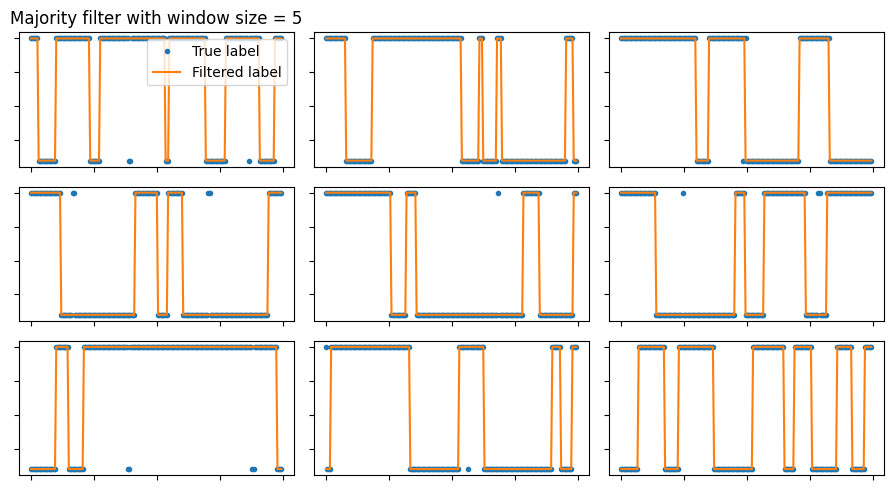

In [ ]:
fig, axs = plt.subplots(3, 3, figsize = (9, 5), tight_layout = True)
window_size = 5

for ax in axs.flatten():    
    traj, labs = models_phenom()._multiple_state_traj(alphas = [0.7, 0.8], Ds = [0.01, 0.1])
    filtered_d = label_filter(labs[:,1],
                              window_size = window_size)
    
    ax.plot(labs[:, 1], '.', label = 'True label')
    ax.plot(filtered_d, label = r'Filtered label')
    
axs[0,0].set_title(f'Majority filter with window size = {window_size}')
axs[0,0].legend()
plt.setp(axs, xticklabels = [], yticklabels = []);

### New population percentages after filtering
Note that smoothing the signal will have an effect on the actual proportion of time a particle spends in each state. This will be taken into account in the challenge. Here we showcase this effect:

In [ ]:
#| hide
#| eval: false
from andi_datasets.models_phenom import models_phenom
from tqdm.notebook import tqdm

In [ ]:
#| eval: false
T = 100
traj, labs = models_phenom().multi_state(N = 500, alphas = [[0.7, 1],[0.4,2]], Ds = [[0, 1], [1, 0]], T = T)

In [ ]:
#| eval: false
res_t = np.array([])
res_ft = np.array([])
for label in tqdm(labs.transpose(1,0,2)[:,:,0]):
    
    # raw labels
    CP = np.argwhere(label[1:] != label[:-1]).flatten()
    if CP[-1] != 199: CP = np.append(CP, T-1)
    CP = np.append(0, CP)

    res_t = np.append(res_t, CP[1:] - CP[:-1])
    
    
    # filtered labels
    filt = label_filter(label)
    
    CP_f = np.argwhere(filt[1:] != filt[:-1]).flatten()
    if CP_f[-1] != 199: CP_f = np.append(CP_f, T-1)
    CP_f = np.append(0, CP_f)

    res_ft = np.append(res_ft, CP_f[1:] - CP_f[:-1])

  0%|          | 0/500 [00:00<?, ?it/s]

We show now the new transition rates (e.g. 1 over the residence time of a given state). Because we are minimum segment length of 3, we can actually approximate the filtered transition rate as the original times 2/3:

In [ ]:
#| eval: false
print(f' True transition rate: {1/np.mean(res_t)}\n',
      f'Filtered transition rate: {1/np.mean(res_ft)}\n',
      f'True rate x 2/3: {1/np.mean(res_t)*(2/3)}')

 True transition rate: 0.10947474747474747
 Filtered transition rate: 0.07402020202020201
 True rate x 2/3: 0.07298316498316498


## Continuous labels to list of features

The labels in the challenge will be the list of $n$ changepoints as well as the $n+1$ diffusion properties ($D$ and $\alpha$) for each segment. This function transforms the stepwise labels into three lists: CPs, $\alpha$s and $D$s.

In [ ]:
#| export
def label_continuous_to_list(labs):
    ''' 
    Given an array of T x 2 labels containing the anomalous exponent and diffusion 
    coefficient at each timestep, returns 3 arrays, each containing the changepoints, 
    exponents and coefficient, respectively. 
    If labs is size T x 3, then we consider that diffusive states are given and also
    return those.
    
    Parameters
    ----------
    labs : array
        T x 2  or T x 3 labels containing the anomalous exponent, diffusion 
        and diffusive state.
        
    Returns
    -------
    tuple
        - First element is the list of change points
        - The rest are corresponding segment properties (order: alpha, Ds and states)        
        '''
    
    # Check if states were given
    are_states = False
    if labs.shape[1] == 3:
        are_states = True
        
    # Check in which variable there is changes
    CP = np.argwhere((labs[:-1, :] != labs[1:, :]).sum(1) != 0).flatten()+1 
    T = labs.shape[0] 

    alphas = np.zeros(len(CP)+1)
    Ds = np.zeros(len(CP)+1)
    if are_states: states = np.zeros(len(CP)+1)
        
    for idx, cp in enumerate(np.append(CP, T)):
        alphas[idx] = labs[cp-1, 0]
        Ds[idx] = labs[cp-1, 1]
        if are_states: states[idx] = labs[cp-1, 2]
    
    CP = np.append(CP, T)
    
    if are_states:
        return CP, alphas, Ds, states
    else:
        return CP, alphas, Ds    

In [ ]:
#| hide
from andi_datasets.models_phenom import models_phenom

Text(0, 0.5, '$\\alpha$')

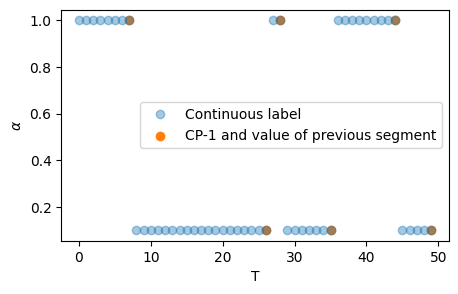

In [ ]:
# Generate the trajectory
trajs, labels = models_phenom().multi_state(N = 1, T = 50)

# Transform the labels:
CP, alphas, Ds, _ = label_continuous_to_list(labels[:,-1,:])

plt.figure(figsize=(5, 3))
plt.plot(labels[:, -1, 1], 'o', alpha = 0.4, label = 'Continuous label')
plt.scatter(CP-1, Ds, c = 'C1', label = 'CP-1 and value of previous segment')
plt.legend(); plt.xlabel('T'); plt.ylabel(r'$\alpha$')

## List of features to continuous labels
This function does the opposite from than `label_continuous_to_list`. From a list of properties as the one used in ANDI 2 challenge, creates continuous labels.

In [ ]:
#| export
def label_list_to_continuous(CP, label):
    '''
    Given a list of change points and the labels of the diffusion properties of the
    resulting segments, generates and array of continuous labels. The last change point
    indicates the array length.
    
    Parameters
    ----------
    CP : array, list
        list of change points. Last change point indicates label length.
    label : array, list
        list of segment properties
        
    Returns
    -------
    array
        Continuous label created from the given change points and segment properties
    '''    
    
    if isinstance(label, list):
        label = np.array(label)
    segs = create_binary_segment(CP[:-1], CP[-1])
    return (segs.transpose()*label).sum(1)

In [ ]:
#| hide
from andi_datasets.utils_challenge import create_binary_segment

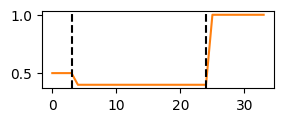

In [ ]:
CP = [3,24,34]
label = [0.5, 0.4, 1]
cont = label_list_to_continuous(CP, label)
plt.figure(figsize = (3,1))
plt.plot(cont, c = 'C1')
[plt.axvline(c, c = 'k', ls = '--') for c in CP[:-1]];

## Storing array data in dataframe

In [ ]:
#| export
from andi_datasets.utils_trajectories import segs_inside_fov


def array_to_df(trajs, 
               labels,
               min_length = 10,
               fov_origin = [0,0], fov_length= 100.0, cutoff_length = 10):
    '''
    Given arrays for the position and labels of trajectories, creates a dataframe with that
    data. The function also applies the demanded FOV. If you don't want a field of view, chose a 
    FOV length bigger (smaller) that your maximum (minimum) trajectory position.
   
    Parameters
    ----------
    trajs : array 
        Trajectories to store in the df (dimension: T x N x 3)
    labels : array
        Labels to store in the df (dimension: T x N x 3)        
    fov_origin : tuple
        Bottom left point of the square defining the FOV.
    fov_length : float
        Size of the box defining the FOV.
    cutoff_length : int
        Minimum length of a trajectory inside the FOV to be considered in the output dataset.
    
    
    Returns
    -------
    tuple
        - df_in (dataframe): dataframe with trajectories
        - df_out (datafram): dataframe with labels 
    '''
    
    xs = []
    ys = []
    idxs = []   
    
    df_out = pandas.DataFrame(columns = ['traj_idx', 'Ds', 'alphas', 'states', 'changepoints']) 
    
    idx_t = 0
    for traj, l_alpha, l_D, l_s in zip(tqdm(trajs), labels[:, :, 0], labels[:, :, 1], labels[:, :, 2]):

        # Check FOV and 
        idx_inside_segments = segs_inside_fov(traj, fov_origin, fov_length, cutoff_length)

        if idx_inside_segments is not None:

            for idx_in in idx_inside_segments:            
                seg_x = traj[idx_in[0]:idx_in[1], 0]
                seg_y = traj[idx_in[0]:idx_in[1], 1]
                seg_alpha = l_alpha[idx_in[0]:idx_in[1]]
                seg_D = l_D[idx_in[0]:idx_in[1]]
                seg_state = l_s[idx_in[0]:idx_in[1]]

                # Filtering
                seg_alpha = label_filter(seg_alpha)
                seg_D = label_filter(seg_D)
                seg_state = label_filter(seg_state)
                
                
                # Stacking data of input dataframe
                xs += seg_x.tolist()
                ys += seg_y.tolist()
                idxs += (np.ones(len(seg_x))*idx_t).tolist()
                
                # Transforming to list of changepoints and physical properties
                merge = np.hstack((seg_alpha.reshape(seg_alpha.shape[0], 1),
                                   seg_D.reshape(seg_D.shape[0], 1),
                                   seg_state.reshape(seg_state.shape[0], 1)))
                
                CP, alphas, Ds, states = label_continuous_to_list(merge)
                
                # Saving each segment info in output dataframe
                df_out.loc[df_out.shape[0]] = [idx_t, Ds, alphas, states, CP]
                
                # Updating segment index
                idx_t += 1

    
    # Saving trajectories in Dataframe
    tr_to_df = np.vstack((idxs,
                          xs,
                          ys)).transpose()
    df_in = pandas.DataFrame(tr_to_df, columns = ['traj_idx', 'x', 'y'])  
    
    return df_in, df_out

In [ ]:
#| hide
from andi_datasets.models_phenom import models_phenom
from andi_datasets.utils_challenge import label_filter, label_continuous_to_list

In [ ]:
#trajs, labels = models_phenom().multi_state(T = 200, N = 10, alphas=[0.5, 1], Ds = [1,1], L = 100)
trajs, labels = models_phenom().single_state(T = 200, N = 10)

# Changing dimensions
trajs = trajs.transpose((1, 0, 2)).copy()
labels = labels.transpose(1, 0, 2)

df_in, df_out = array_to_df(trajs, labels)

In [ ]:
df_out.head()

,traj_idx,Ds,alphas,states,changepoints
0,0,[1.0],[1.0],[2.0],[115]
1,1,[1.0],[1.0],[2.0],[22]
2,2,[1.0],[1.0],[2.0],[10]
3,3,[1.0],[1.0],[2.0],[39]
4,4,[1.0],[1.0],[2.0],[28]


## Transform ANDI dataframe to array with padding

In [ ]:
#| export
def df_to_array(df, pad = -1):
    '''
    Transform a dataframe as the ones given in the ANDI 2 challenge (i.e. 4 columns:
    traj_idx, frame, x, y) into a numpy array. To deal with irregular temporal supports,
    we pad the array whenever the trajectory is not present.
    The output array has the typical shape of ANDI datasets: TxNx2
    
    Parameters
    ----------
    df : dataframe
        Dataframe with four columns 'traj_idx': the trajectory index, 'frame' the time frame and 
        'x' and 'y' the positions of the particle.
    pad : int
        Number to use as padding.
    
    Returns
    -------
    array
        Array containing the trajectories from the dataframe, with usual ANDI shape (TxNx2).
    
    
    '''

    max_T = int(df.frame.max()+1)
    num_part = int(df.iloc[-1].traj_idx)
    array_trajs = np.ones((max_T, num_part+1, 2))*pad

    for idx in np.unique(df.traj_idx).astype(int):

        df_part = df.loc[df.traj_idx == idx]

        array_trajs[df_part.frame.values.astype(int), idx, 0] = df_part.x.values
        array_trajs[df_part.frame.values.astype(int), idx, 1] = df_part.y.values
        
    return array_trajs

## Reorganize folder for challenge if non-overlapping FOVS
The outputs of `datasets_challenge.challenge_phenom_dataset` are not in the appropriate form if one considers the case of non-overlapping FOVS. The latter means that instead of taking `n_fovs` from the same experiment, we repeat the same experiment `n_fovs` times. This functions rearranges the folders to get the proper structure proposed in the paper.

In [ ]:
#| export
from pathlib import Path
import shutil

def file_nonOverlap_reOrg(# Original folder with data produced by datasets_challenge.challenge_phenom_dataset
                          raw_folder: str, 
                          # Folder where to put reorganized files
                          target_folder: str, 
                          # Number of experiments
                          experiments: int, 
                          # Number of FOVS
                          num_fovs: int,                          
                          # Track to consider
                          tracks = [1,2],
                          # If True, moves all data (also labels,.. etc). Do True only if saving reference / groundtruth data.
                          # Moreover, if True also save the trajectories for the video track
                          save_labels = False, 
                          # Which task to consider
                          task = ['single', 'ensemble'],
                          # If True prints, the percentage of states for each experiment
                          print_percentage = True):
    ''' 
    This considers that you have n_fovs*n_experiments 'fake' experiments 
    and organize them based on the challenge instructions
    
    '''
    
    if save_labels:
        names_files = ['traj_labs_', 'trajs_', 'videos_', 'ens_labs_', 'vip_idx_']
        extensions = ['.txt', '.csv', '.tiff', '.txt', '.txt']
    else:
        names_files = ['trajs_', 'videos_']
        extensions = ['.csv', '.tiff']

    exp = 0
    ensemble_info = []
    # Get model and num_states
    info_exp = np.loadtxt(raw_folder + f'ens_labs_exp_0_fov_0.txt', max_rows=1, dtype = str)
    model_exp, num_states = info_exp[1][:-1], info_exp[-1].astype(int)
    percentage_exp = np.zeros((num_fovs, num_states))

    for k in range(num_fovs*len(experiments)):        
        
        # ----- Check when we are done with one experiment and go to next -----
        if (k % num_fovs == 0 and k != 0):
            
            # First save the ensemble information of the current experiment
            if num_states > 1:
                percentage_exp = np.sum(percentage_exp, axis = 0)
                percentage_exp /= percentage_exp.sum()                                  
                ensemble_fov[-1,:] =  percentage_exp                  
            if num_states == 1:
                ensemble_fov[-1] = 1
            if print_percentage:
                    print(f'Experiment {exp}: {np.round(ensemble_fov[-1], 2)}')
            
            if save_labels:
                for track in tracks:
                    with open(target_folder + f'track_{track}/exp_{exp}/ensemble_labels.txt', 'w') as f:
                        f.truncate(0)
                        f.write(f'model: {model_exp}; num_state: {num_states} \n')
                        np.savetxt(f, ensemble_fov, delimiter = ';')

            # Then restart for next experiment
            exp += 1
            ensemble_info = []
            info_exp = np.loadtxt(raw_folder + f'ens_labs_exp_{k}_fov_0.txt', max_rows=1, dtype = str)
            model_exp, num_states = info_exp[1][:-1], info_exp[-1].astype(int)
            percentage_exp = np.zeros((num_fovs, num_states))   
            
        
        # ----- Move the folders -----
        for track in tracks:
            Path(target_folder+f'track_{track}/'+f'exp_{exp}').mkdir(parents=True, exist_ok=True)

            # Move single trajectory information
            for name, ext in zip(names_files, extensions):            
                if track == 1 and name == 'trajs_' and save_labels == False: continue
                if track == 2 and (name == 'videos_' or name == 'vip_idx_'): continue

                shutil.copyfile(src = raw_folder + name + f'exp_{k}_fov_0'+ext, 
                                dst = target_folder + f'track_{track}/exp_{exp}/' + name + f'fov_{k%num_fovs}' + ext)
        

        ### ----- Collect ensemble information -----
        ensemble_fov = np.loadtxt(raw_folder + f'ens_labs_exp_{k}_fov_0.txt', 
                                  skiprows = 1, delimiter = ';')
        if num_states > 1:
            percentage_exp[k%num_fovs] = ensemble_fov[-1, :].copy()
            
    # Save the ensemble information of the LAST experiment
    if num_states > 1:
        percentage_exp = np.sum(percentage_exp, axis = 0)
        percentage_exp /= percentage_exp.sum()                                  
        ensemble_fov[-1,:] =  percentage_exp                  
    if num_states == 1:
        ensemble_fov[-1] = 1
    if print_percentage:
            print(f'Experiment {exp}: {np.round(ensemble_fov[-1], 2)}')
    
    if save_labels:
        for track in tracks:
            with open(target_folder + f'track_{track}/exp_{exp}/ensemble_labels.txt', 'w') as f:
                f.truncate(0)
                f.write(f'model: {model_exp}; num_state: {num_states} \n')
                np.savetxt(f, ensemble_fov, delimiter = ';')

                    

# Isolate VIP particles

In [ ]:
#| export
from scipy.spatial import distance


def get_VIP(array_trajs, num_vip = 5, min_distance_part = 2, pad = -1, 
            boundary = False, boundary_origin = (0,0), min_distance_bound = 0,
            sort_length = True):
    '''
    Given an array of trajectories, finds the particles VIP particles that participants will
    need to characterize in the video trakcl.
    
    The function first finds the particles that exist at frame 0 (i.e. that their first value 
    is different from pad). Then, iterates over this particles to find num_vip that are at 
    distance > than min_distance_part in the first frame.
    
    Parameters
    ----------
    array_trajs : array
        Position of the trajectories that will be considered for the VIP search.
    num_vip : int
        Number of VIP particles to flag.
    min_distance_part : float
        Minimum distance between two VIP particles.
    pad : int
        Number used to indicate in the temporal support that the particle is outside of the FOV.
    boundary : bool, float
        If float, defines the length of the box acting as boundary
    boundary_origin : tuple
        X and Y coords of the boundary
    min_distance_bound : float
        Minimum distance a particles has to be from the boundary in ordered to be considered a VIP particle
    sort_length : bool
        If True, candidates for VIP particles are choosen in descending trajectory length. This ensures
        that the longest ones are chosen.
        
    Returns
    -------
    list
        List of indices of the chosen VIP particles
    
    '''
    if not boundary:
        candidates_vip = np.argwhere(array_trajs[0,:,0] != pad).flatten()
    else:
        # Define masks
        boundary_x0 = array_trajs[0,:,0] > (boundary_origin[0] + min_distance_bound)
        boundary_xL = array_trajs[0,:,0] < (boundary_origin[0] + boundary - min_distance_bound)
        boundary_y0 = array_trajs[0,:,1] > (boundary_origin[1] + min_distance_bound)
        boundary_yL = array_trajs[0,:,1] < (boundary_origin[1] + boundary - min_distance_bound)
        padding = array_trajs[0,:,0] != pad
        
        candidates_vip = np.argwhere(boundary_x0 & boundary_xL & boundary_y0 & boundary_yL & padding).flatten()        
        
    if len(candidates_vip) < num_vip:
        raise ValueError('Number of VIP demanded is bigger than available particles.')

    elected = []
    count_while = 0    
    
    if sort_length:
        array_candidates = array_trajs[:, candidates_vip, :]
        lengths = np.ones(array_candidates.shape[1])*array_candidates.shape[0]
        where_pad = np.argwhere(array_candidates[:,:,0] == pad)
        lengths[where_pad[:,1]] = where_pad[:,0]
        # We sort the particle by their lenghts (note the minus for descending order)
        candidates_vip = candidates_vip[np.argsort(-lengths)]
        
    while len(elected) < num_vip:
        
        if sort_length and count_while == 0: 
            # if we already did a while loop, we start with a random candidate even
            # when sorting
            elected = [candidates_vip[0]]
        else:
            elected = [np.random.choice(candidates_vip)]

        for c_idx in candidates_vip:
            if c_idx == elected[0]:
                continue
            if len(array_trajs[0, elected,:].shape) < 2:
                all_rest = np.expand_dims(array_trajs[0, elected,:], 0)
            else:
                all_rest = array_trajs[0, elected,:]

            dist = distance.cdist(np.expand_dims(array_trajs[0,c_idx,:], 0), all_rest, metric='euclidean').transpose()

            if dist.min() > min_distance_part:
                elected.append(c_idx)

            if len(elected) == num_vip:
                break


        count_while += 1
        if count_while > 100: 
            raise ValueError('Could not find suitable VIP particles. This is due to either having to few particles or them being too close')
            
    return elected


In [ ]:
# define random trajectories
array_trajs = np.random.rand(200,10, 2)*10
# insert paddings to make first trajectories finish earlier
pad = -1
array_trajs[100, :,:] = pad
array_trajs[0,3,0] = pad
array_trajs.shape

(200, 10, 2)

In [ ]:
get_VIP(array_trajs, num_vip = 5, min_distance_part = 0, pad = pad, 
        boundary = 10, boundary_origin = (0,0), min_distance_bound = 0,
        sort_length = True)

[0, 1, 2, 4, 5]

# ANDI 2 challenge metrics

## Setting maximum erros for different metrics

In [ ]:
#| export
def _get_error_bounds():
    '''
    Sets the current maximum errors we can do in the different diffusive properties.
    '''
    
    # For single trajectory
    threshold_error_alpha = 2
    threshold_error_D = 1e5
    threshold_error_s = 0
    threshold_cp = 10
    
    # For ensemble, it relates to the Wasserstein distance. Check test below distribution_distance function 
    threshold_ensemble_alpha = np.abs(models_phenom().bound_alpha[0]-models_phenom().bound_alpha[1])
    threshold_ensemble_D = np.abs(models_phenom().bound_D[0]-models_phenom().bound_D[1])
    
    return threshold_error_alpha, threshold_error_D, threshold_error_s, threshold_cp, threshold_ensemble_alpha, threshold_ensemble_D

## Changepoint pairing
We use an assignment algorithm to pair predicted and groundtruth changepoints. From there, we will calculate the various metrics of the challenge.

In [ ]:
#| export
def changepoint_assignment(GT, preds):
    ''' 
    Given a list of groundtruth and predicted changepoints, solves the assignment problem via
    the Munkres algorithm (aka Hungarian algorithm) and returns two arrays containing the index of the
    paired groundtruth and predicted changepoints, respectively.
    
    The distance between change point is the Euclidean distance.
    
    Parameters
    ----------
    GT : list
        List of groundtruth change points.
    preds : list
        List of predicted change points.
    
    Returns
    -------
    tuple
        - tuple of two arrays, each corresponding to the assigned GT and pred changepoints
        - Cost matrix
    
    '''
    
    cost_matrix = np.zeros((len(GT), len(preds)))

    for idxg, gt in enumerate(GT):
        for idxp, pred in enumerate(preds):
            cost_matrix[idxg, idxp] = np.abs(gt-pred)
            
    return linear_sum_assignment(cost_matrix), cost_matrix

In [ ]:
ngts = 10; npreds = 6; T = 100
GT = np.sort(np.random.choice(np.arange(1,T), ngts, replace = False))
preds = np.sort(np.random.choice(np.arange(1,T)*0.5, npreds, replace = False)).astype(int)
print('GT:', GT)
print('Pred:', preds)
changepoint_assignment(GT, preds)[0]

GT: [ 2  8 24 33 34 54 55 64 73 85]
Pred: [ 8 11 16 30 36 47]


(array([0, 1, 2, 3, 4, 5], dtype=int64),
 array([1, 0, 2, 3, 4, 5], dtype=int64))

In [ ]:
#| export
def changepoint_alpha_beta(GT, preds, threshold = 10):
    '''
    Calculate the alpha and beta measure of paired changepoints.
    Inspired from Supplemantary Note 3 in https://www.nature.com/articles/nmeth.2808
    
    Parameters
    ----------
    GT : list
        List of groundtruth change points.
    preds : list
        List of predicted change points.
    threshold : float
        Distance from which predictions are considered to have failed. They are then assigned this number.
    
    Returns
    -------
    tuple
        alpha, beta
        
    '''

    assignment, _ = changepoint_assignment(GT, preds)
    assignment = np.array(assignment)

    threshold = 10
    distance = np.abs(GT[assignment[0]] - preds[assignment[1]])
    distance[distance > threshold] = threshold
    distance = np.sum(distance)

    d_x_phi = threshold*len(GT)
    d_ybar_phi = max([0, (len(preds)-len(GT))*threshold])

    alpha = 1-distance/d_x_phi
    beta = (d_x_phi-distance)/(d_x_phi+d_ybar_phi)

    return alpha, beta

<matplotlib.legend.Legend>

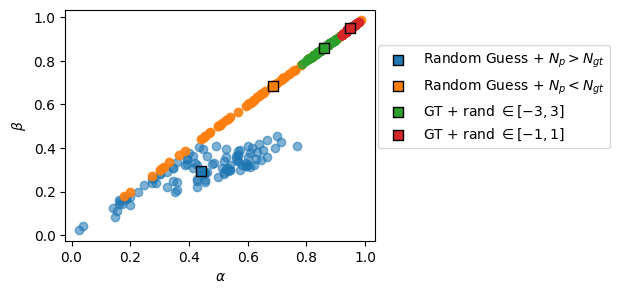

In [ ]:
labels = [r'Random Guess + $N_p>N_{gt}$',
          r'Random Guess + $N_p<N_{gt}$',
          r'GT + rand $\in [-3, 3]$',
          r'GT + rand $\in [-1, 1]$']

fig, ax = plt.subplots(figsize = (4,3))
alpha = 0.2

T = 200; ngts = 15; 

for case, (label, color) in enumerate(zip(labels, ['C0', 'C1', 'C2', 'C3'])):

    alphas, betas = [], []
    for _ in range(100):
        
        GT = np.sort(np.random.choice(np.arange(1,T), ngts, replace = False))
        if case == 0:
            npreds = np.random.randint(low = ngts, high = ngts*2)
            preds = np.sort(np.random.choice(np.arange(1,T), npreds, replace = False)) 
        elif case == 1:
            npreds = np.random.randint(low = 1, high = ngts)
            preds = np.sort(np.random.choice(np.arange(1,T), npreds, replace = False))     
        elif case == 2:
            preds = GT + np.random.randint(-3, 3, ngts)
        elif case == 3:
            preds = GT + np.random.randint(-1, 1, ngts)
            
        alpha, beta = changepoint_alpha_beta(GT, preds)
        
        alphas.append(alpha)
        betas.append(beta)
     
    
    ax.scatter(alphas, betas, c = color, alpha = alpha)
    ax.scatter(np.mean(alphas), np.mean(betas), c = color, label = label, s = 50, marker = 's', edgecolors = 'k')
plt.setp(ax, xlabel = r'$\alpha$', ylabel = r'$\beta$')
ax.legend(loc = (1.01,0.4))

In [ ]:
#| export
def jaccard_index(TP: int, # true positive
                  FP: int, # false positive
                  FN: int # false negative
                 )-> float: # Jaccard Index
    '''
    Given the true positive, false positive and false negative rates, calculates the Jaccard Index
    '''
    return TP/(TP+FP+FN)

In [ ]:
#| export
def single_changepoint_error(GT, preds, threshold = 5):
    '''
    Given the groundtruth and predicted changepoints for a single trajectory, first solves the assignment problem between changepoints,
    then calculates the RMSE of the true positive pairs and the Jaccard index.
    
    Parameters
    ----------
    GT : list
        List of groundtruth change points.
    preds : list
        List of predicted change points.
    threshold : float
        Distance from which predictions are considered to have failed. They are then assigned this number.
    
    Returns
    -------
    tuple
        - TP_rmse: root mean square error of the true positive change points.
        - Jaccard Index of the ensemble predictions        
        
    '''
    
    assignment, _ = changepoint_assignment(GT, preds)
    assignment = np.array(assignment)
    
    TP, FP, FN = 0, 0, 0
    TP_rmse = []
    for p in assignment.transpose():
        
        if np.abs(GT[p[0]] - preds[p[1]]) < threshold:
            TP += 1
            TP_rmse.append((GT[p[0]] - preds[p[1]])**2)
        else:
            FP += 1
            FN += 1
    # Calculating RMSE
    TP_rmse = np.sqrt(np.mean(TP_rmse))

    # Checking false positive and missed events
    if len(preds) > len(GT):
        FP += len(preds) - len(GT)
    elif len(preds) < len(GT):
        FN += len(GT) - len(preds)
    
    return TP_rmse, jaccard_index(TP, FP, FN)

In [ ]:
#| export
def ensemble_changepoint_error(GT_ensemble, pred_ensemble, threshold = 5):    
    ''' 
    Given an ensemble of groundtruth and predicted change points, iterates
    over each trajectory's changepoints. For each, it solves the assignment problem 
    between changepoints. Then, calculates the RMSE of the true positive pairs and
    the Jaccard index over the ensemble of changepoints (i.e. not the mean of them 
    w.r.t. to the trajectories)
    
    Parameters
    ----------
    GT_ensemble : list, array
        Ensemble of groutruth change points.
    pred_ensemble : list
        Ensemble of predicted change points.
    threshold : float
        Distance from which predictions are considered to have failed. They are then assigned this number.
    
    Returns
    -------
    tuple
        - TP_rmse: root mean square error of the true positive change points.
        - Jaccard Index of the ensemble predictions
    
    '''
    
    TP, FP, FN = 0, 0, 0
    TP_rmse = []
    num_cp_GT = 0
    for gt_traj, pred_traj in zip(GT_ensemble, pred_ensemble):
        num_cp_GT += len(gt_traj)
        
        assignment, _ = changepoint_assignment(gt_traj, pred_traj)
        assignment = np.array(assignment)
        
        for p in assignment.transpose():
            
            if np.abs(gt_traj[p[0]] - pred_traj[p[1]]) < threshold:
                TP += 1
                TP_rmse.append((gt_traj[p[0]] - pred_traj[p[1]])**2)
            else:
                FP += 1
                FN += 1    
                
        # Checking false positive and missed events
        if len(pred_traj) > len(gt_traj):
            FP += len(pred_traj) - len(gt_traj)
        elif len(pred_traj) < len(gt_traj):
            FN += len(gt_traj) - len(pred_traj)
                
    if TP+FP+FN == 0:
        if num_cp_GT == 0: # this means there where no CP both in GT and Pred
            return 0, 1
        wrn_str = f'No segments found in your predictions dataset.'
        warnings.warn(wrn_str)
        return threshold, 0
        
    # Calculating RMSE
    if len(TP_rmse) > 0:
        TP_rmse = np.sqrt(np.mean(TP_rmse))
    else:
        TP_rmse = threshold
    
        
    return TP_rmse, jaccard_index(TP, FP, FN)

<matplotlib.legend.Legend>

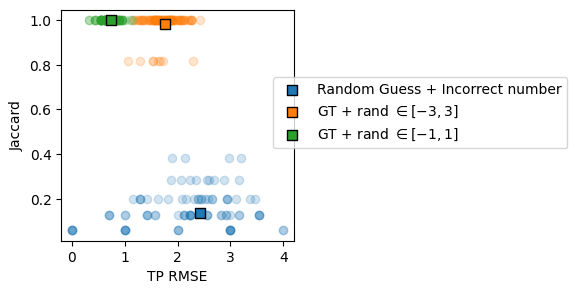

In [ ]:
labels = ['Random Guess + Incorrect number',
          r'GT + rand $\in [-3, 3]$',
          r'GT + rand $\in [-1, 1]$']

fig, ax = plt.subplots(figsize = (3,3))
alpha = 0.2

T = 200; ngts = 10; npreds = 8

for case, (label, color) in enumerate(zip(labels, ['C0', 'C1', 'C2'])):
    
    rmse, ji = [], []
    GT, preds = [], []
    for _ in range(100):

        GT.append(np.sort(np.random.choice(np.arange(1,T), ngts, replace = False)))
        if case == 0:
            preds.append(np.sort(np.random.choice(np.arange(1,T), npreds, replace = False)))                  
        elif case == 1:
            preds.append(GT[-1] + np.random.randint(-3, 3, ngts))
        elif case == 2:
            preds.append(GT[-1] + np.random.randint(-1, 1, ngts))

        assignment, _ = changepoint_assignment(GT[-1], preds[-1])
        assignment = np.array(assignment)

        RMSE, JI = single_changepoint_error(GT[-1], preds[-1], threshold = 5)     
        
        rmse.append(RMSE)
        ji.append(JI)

    rmse_e, ji_e = ensemble_changepoint_error(GT, preds, threshold = 5)
    
    ax.scatter(rmse, ji, c = color, alpha = alpha)
    ax.scatter(rmse_e, ji_e, c = color, label = label, s = 50, marker = 's', edgecolors = 'k')
plt.setp(ax, xlabel = 'TP RMSE', ylabel = 'Jaccard')
ax.legend(loc = (0.91,0.4))

## Segments pairing 
Here we focus on pairing the segments arising from a list of changepoints. We will use this to latter compare the predicted physical properties for each segment

In [ ]:
#| export
def create_binary_segment(CP: list, # list of changepoints
                          T: int # length of the trajectory
                         )-> list: # list of arrays with value 1 in the temporal support of the current segment.
    '''
    Given a set of changepoints and the lenght of the trajectory, create segments which are equal to one
    if the segment takes place at that position and zero otherwise.
    '''
    segments = np.zeros((len(CP)+1, T))
    CP = np.append(0, CP)
    for idx, (cp1, cp2) in enumerate(zip(CP[:-1], CP[1:])):
        segments[idx, cp1+1:cp2+1] = 1
    segments[-1, CP[-1]+1:] = 1
    segments[0, 0] = 1
    return segments

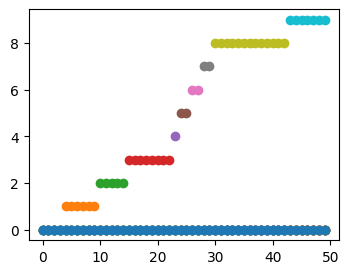

In [ ]:
T= 50
GT = np.sort(np.random.choice(np.arange(1,T), 10, replace = False))
plt.figure(figsize = (4,3))
for idx, x in enumerate(create_binary_segment(GT, T)):
    plt.plot(x*idx, 'o')

In [ ]:
#| export
def jaccard_between_segments(gt, pred):
    '''
    Given two segments, calculates the Jaccard index between them by considering TP as correct labeling,
    FN as missed events and FP leftover predictions.
    
    Parameters
    ----------
    gt : array
        groundtruth segment, equal to one in the temporal support of the given segment, zero otherwise.
    pred : array
        predicted segment, equal to one in the temporal support of the given segment, zero otherwise.
    
    Returns
    -------
    float
        Jaccard index between the given segments.
    '''
    
    if len(gt) > len(pred):
        pred = np.append(pred, np.zeros(len(gt) - len(pred)))
    elif len(pred) > len(gt):                        
        gt = np.append(gt, np.zeros(len(pred) - len(gt)))
    
    
    tp = np.sum(np.logical_and(pred == 1, gt == 1))
    fp = np.sum(np.logical_and(pred == 1, gt == 0))
    fn = np.sum(np.logical_and(pred == 0, gt == 1))
    
    # special case for absence of changepoint
    if tp+fp+fn == 0: return 0    
    else: return jaccard_index(tp, fp, fn)

In [ ]:
#| export
def segment_assignment(GT, preds, T:int = None):
    ''' 
    Given a list of groundtruth and predicted changepoints, generates a set of segments. Then constructs 
    a cost matrix by calculting the Jaccard Index between segments. From this cost matrix, we solve the 
    assignment  problem via the Munkres algorithm (aka Hungarian algorithm) and returns two arrays 
    containing the index of the groundtruth and predicted segments, respectively.
    
    If T = None, then we consider that GT and preds may have different lenghts. In that case, the end
    of the segments is the the last CP of each set of CPs.
    
    Parameters
    ----------
    GT : list
        List of groundtruth change points.
    preds : list
        List of predicted change points.
    T : int, None
        Length of the trajectory. If None, considers different GT and preds length.
    
    Returns
    -------
    tuple
        - tuple of two arrays, each corresponding to the assigned GT and pred changepoints
        - Cost matrix calculated via JI of segments   
    
    '''
   
    if T is not None:
        T_gt = T_pred = T
        # Check if the GT or predictions are a single integer or an empty array
        if isinstance(GT, int): GT = [GT]
        elif len(GT) == 0: GT = [T-1]

        if isinstance(preds, int): preds = [preds]
        elif len(preds) == 0: preds = [T-1]
    else:
        T_gt = GT[-1]
        if len(GT) > 1:
            GT = GT[:-1]            
            
        T_pred = preds[-1]
        if len(preds) > 1:
            preds = preds[:-1]
        
    
    
    seg_GT = create_binary_segment(GT, T_gt)
    seg_preds = create_binary_segment(preds, T_pred)
    
    cost_matrix = np.zeros((seg_GT.shape[0], seg_preds.shape[0]))

    for idxg, gt in enumerate(seg_GT):
        for idxp, pred in enumerate(seg_preds):
            cost_matrix[idxg, idxp] = 1-jaccard_between_segments(gt, pred)

    return linear_sum_assignment(cost_matrix), cost_matrix

#### Examples

**Predictions close to groundtruth**

<matplotlib.legend.Legend>

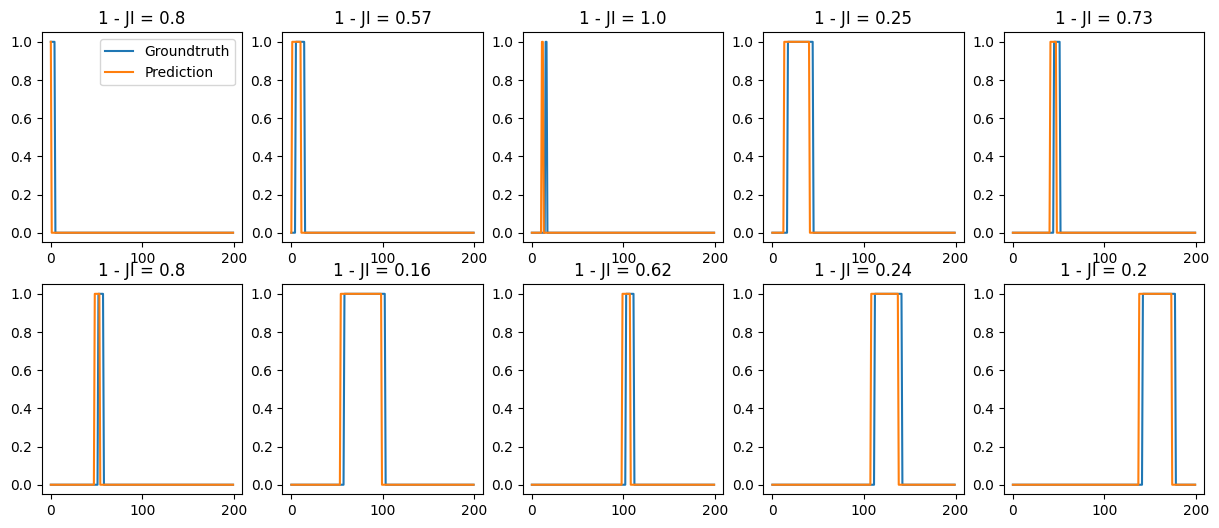

In [ ]:
T = 200; 
ngts = 10; 
GT = np.sort(np.random.choice(np.arange(1,T), ngts, replace = False))
preds = np.sort(GT + np.random.randint(-5, 5, 1) )

seg_GT = create_binary_segment(GT, T)
seg_preds = create_binary_segment(preds, T)   

[row_ind, col_ind], cost_matrix = segment_assignment(GT, preds, T)

fig, axs = plt.subplots(2, 5, figsize = (15, 6))
for r, c, ax in zip(row_ind, col_ind, axs.flatten()):
    ax.set_title(f'1 - JI = {np.round(cost_matrix[r, c], 2)}')
    ax.plot(seg_GT[r], label = 'Groundtruth')
    ax.plot(seg_preds[c], label = 'Prediction')
axs[0,0].legend()

**Different size between predictions and trues**

<matplotlib.legend.Legend>

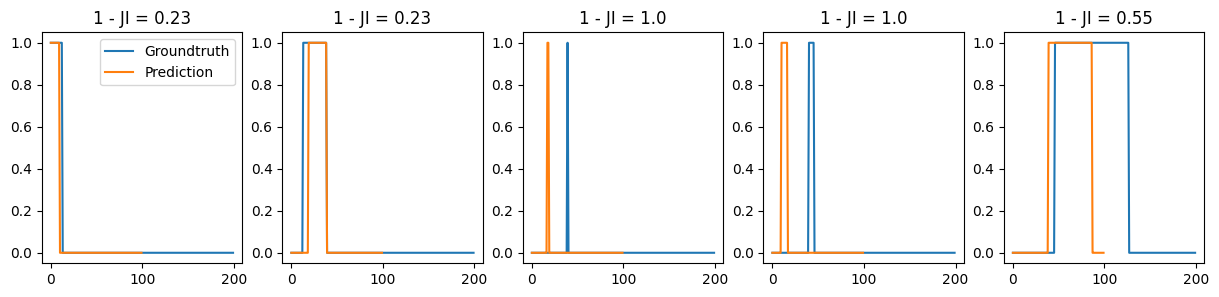

In [ ]:
T1 = 200; T2 = 100
ngts = 10; 
GT = np.sort(np.random.choice(np.arange(1,T1), ngts, replace = False))
preds = np.sort(np.random.choice(np.arange(1,T2), 5, replace = False))

seg_GT = create_binary_segment(GT, T1)
seg_preds = create_binary_segment(preds, T2)   

[row_ind, col_ind], cost_matrix = segment_assignment(GT, preds)

fig, axs = plt.subplots(1, 5, figsize = (15, 3))
for r, c, ax in zip(row_ind, col_ind, axs.flatten()):
    ax.set_title(f'1 - JI = {np.round(cost_matrix[r, c], 2)}')
    ax.plot(seg_GT[r], label = 'Groundtruth')
    ax.plot(seg_preds[c], label = 'Prediction')
axs[0].legend()

**Predictions very different to groundtruth**

<matplotlib.legend.Legend>

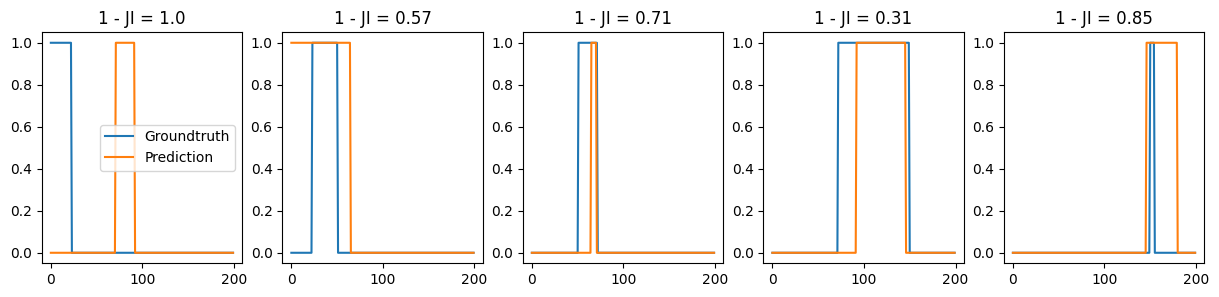

In [ ]:
T = 200;
ngts = 5; npreds = 5;
GT = np.sort(np.random.choice(np.arange(1,T), ngts, replace = False))
preds = np.sort(np.random.choice(np.arange(1,T), npreds, replace = False))  

seg_GT = create_binary_segment(GT, T)
seg_preds = create_binary_segment(preds, T)

[row_ind, col_ind], cost_matrix = segment_assignment(GT, preds, T)

fig, axs = plt.subplots(1, 5, figsize = (15, 3))
for r, c, ax in zip(row_ind, col_ind, axs.flatten()):
    ax.set_title(f'1 - JI = {np.round(cost_matrix[r, c], 2)}')
    ax.plot(seg_GT[r], label = 'Groundtruth')
    ax.plot(seg_preds[c], label = 'Prediction')
axs[0].legend()

## Segment properties comparison

We use the segment pairing functions that we have defined above to compute various metrics between the properties of predicted and groundtruth segments.


### Metrics of segment properties

In [ ]:
#| export
from sklearn.metrics import mean_squared_log_error as msle, f1_score

def metric_anomalous_exponent(gt = None,
                              pred = None,
                              max_error = np.abs(models_phenom().bound_alpha[0]-models_phenom().bound_alpha[1])):
    ''' 
    Compute the mean absolute error (mae) between anomalous exponents.
    Checks the current bounds of anomalous exponents from models_phenom to calculate the maximum error.
    ''' 
    error = np.mean(np.abs(gt-pred))
    if error > max_error:
        return max_error
    else: 
        return error

def metric_diffusion_coefficient(gt = None, pred = None, 
                                 threshold_min = models_phenom().bound_D[0],                               
                                 max_error = msle([models_phenom().bound_D[0]],
                                                  [models_phenom().bound_D[1]])):
    ''' 
    Compute the mean squared log error (msle) between diffusion coefficients.
    Checks the current bounds of diffusion from models_phenom to calculate the maximum error. 
    ''' 
    
     # considering the presence of zeros and negatives
    pred = np.array(pred).copy(); gt = np.array(gt).copy()
    pred[pred <= threshold_min] = threshold_min
    gt[gt <= threshold_min] = threshold_min    
    # mean squared log error
    error = msle(gt, pred)
    
    if error > max_error:
        return max_error
    else: 
        return error

def metric_diffusive_state(gt = None, pred = None):
    ''' 
    Compute the F1 score between diffusive states. 
    ''' 
    return f1_score(gt.astype(int), pred.astype(int), average = 'micro')

In [ ]:
x = np.random.rand(100)
y = np.random.rand(100)

In [ ]:
metric_diffusion_coefficient(x+2,y+2, threshold_min=-2)

0.014261449910975834

### Pairing and metrics calculation

In [ ]:
#| export
def check_no_changepoints(GT_cp, GT_alpha, GT_D, GT_s,
                          preds_cp, preds_alpha, preds_D, preds_s,
                          T:bool|int = None):
    '''
    Given predicionts over changepoints and variables, checks if in both GT and preds there is an 
    absence of change point. If so, takes that into account to pair variables.
    
    Parameters
    ----------
    GT_cp : list, int, float
        Groundtruth change points
    GT_alpha : list, float
        Groundtruth anomalous exponent
    GT_D : list, float
        Groundtruth diffusion coefficient
    GT_s : list, float
        Groundtruth diffusive state
    preds_cp : list, int, float
        Predicted change points
    preds_alpha : list, float
        Predicted anomalous exponent
    preds_D : list, float
        Predicted diffusion coefficient
    preds_s : list, float
        Predicted diffusive state
    T : bool,int
        (optional) Length of the trajectories. If none, last change point is length.
    
    Returns
    -------
    tuple
        - False if there are change points. True if there were missing change points.
        - Next three are either all Nones if change points were detected, or paired exponents, 
        coefficient and states if some change points were missing.
    
    '''


    if isinstance(GT_cp, int) or isinstance(GT_cp, float):
        GT_cp = [GT_cp]
    if isinstance(preds_cp, int) or isinstance(preds_cp, float):
        preds_cp = [preds_cp]
        
    no_GT_cp = False; no_preds_cp = False
    # CP always contain the final point of the trajectory, hence minimal length is one
    if len(GT_cp) == 1: no_GT_cp = True
    if len(preds_cp) == 1: no_preds_cp = True       
        

    if no_GT_cp + no_preds_cp == 0:
        return False, None, None, None
    
    else:

        [row_ind, col_ind], _ = segment_assignment(GT_cp, preds_cp, T)   

        if no_GT_cp and not no_preds_cp:
            paired_alpha = np.array([[GT_alpha[0], preds_alpha[col_ind[0]]]])
            paired_D = np.array([[GT_D[0], preds_D[col_ind[0]]]])
            paired_s = np.array([[GT_s[0], preds_s[col_ind[0]]]])

        if no_preds_cp and not no_GT_cp:
            row_position = np.argwhere(col_ind == 0).flatten()[0]            
            paired_alpha = np.array([[GT_alpha[row_position], preds_alpha[col_ind[row_position]]]])
            paired_D = np.array([[GT_D[row_position], preds_D[col_ind[row_position]]]])
            paired_s = np.array([[GT_s[row_position], preds_s[col_ind[row_position]]]])
            
        if no_preds_cp and no_GT_cp: 
            paired_alpha = np.array([[GT_alpha[0], preds_alpha[0]]])
            paired_D = np.array([[GT_D[0], preds_D[0]]])
            paired_s = np.array([[GT_s[0], preds_s[0]]])
            

        return True, paired_alpha, paired_D, paired_s

In [ ]:
#| export
def segment_property_errors(GT_cp, GT_alpha, GT_D, GT_s,
                            preds_cp, preds_alpha, preds_D, preds_s,
                            return_pairs = False,
                            T = None):
    '''
    Given predicionts over change points and the value of diffusion parameters in the generated
    segments, computes the defined metrics.
    
    Parameters
    ----------
    GT_cp : list, int, float
        Groundtruth change points
    GT_alpha : list, float
        Groundtruth anomalous exponent
    GT_D : list, float
        Groundtruth diffusion coefficient
    GT_s : list, float
        Groundtruth diffusive state
    preds_cp : list, int, float
        Predicted change points
    preds_alpha : list, float
        Predicted anomalous exponent
    preds_D : list, float
        Predicted diffusion coefficient
    preds_s : list, float
        Predicted diffusive state
    return_pairs : bool
        If True, returns the assigment pairs for each diffusive property.
    T : bool,int
        (optional) Length of the trajectories. If none, last change point is length.
    
    Returns
    -------
    tuple
        - if return_pairs = True, returns the assigned pairs of diffusive properties
        - if return_pairs = False, returns the errors for each diffusive property
    '''
    
    # Check cases in which changepoint where not detected or there were none in groundtruth
    no_change_point_case, paired_alpha, paired_D, paired_s = check_no_changepoints(GT_cp, GT_alpha, GT_D, GT_s,
                                                                                   preds_cp, preds_alpha, preds_D, preds_s, T)
   
    if not no_change_point_case:
        # Solve the assignment problem
        [row_ind, col_ind], _ = segment_assignment(GT_cp, preds_cp, T)
   
        # iterate over the groundtruth segments
        paired_alpha, paired_D, paired_s = [], [], []
        for idx_seg, (gt_alpha, gt_D) in enumerate(zip(GT_alpha, GT_D)):

            row_position = np.argwhere(row_ind == idx_seg).flatten()

            # if the GT segment was associated to a prediction
            if len(row_position) > 0:
                row_position = int(row_position)
                # alpha                
                gt_a_seg = GT_alpha[idx_seg]                
                pred_a_seg = preds_alpha[col_ind[row_position]]
                # d
                gt_d_seg = GT_D[idx_seg]
                pred_d_seg = preds_D[col_ind[row_position]]
                # state
                gt_s_seg = GT_s[idx_seg]
                pred_s_seg = preds_s[col_ind[row_position]]

                paired_alpha.append([gt_a_seg, pred_a_seg])
                paired_D.append([gt_d_seg, pred_d_seg])
                paired_s.append([gt_s_seg, pred_s_seg])

        paired_alpha, paired_D, paired_s = np.array(paired_alpha), np.array(paired_D), np.array(paired_s) 
    
    if return_pairs:
        return paired_alpha, paired_D, paired_s 
    else:
        error_alpha = metric_anomalous_exponent(paired_alpha[:,0], paired_alpha[:,1])
        error_D = metric_diffusion_coefficient(paired_D[:,0], paired_D[:,1])
        error_s = metric_diffusive_state(paired_s[:,0], paired_s[:,1])
        return error_alpha, error_D, error_s

We generate some random predictions to check how the metrics behave. We consider errors also in the change point predictions, hence there will be some segment mismatchings, which will affect the diffusive properties predictions:

In [ ]:
T = 200; 
ngts = 10; 
errors_alpha = np.linspace(0, 1, ngts)
errors_d = np.linspace(0, 10, ngts)
errors_s = np.linspace(0, 1, ngts)

metric_a, metric_d, metric_s = [], [], []
for error_a, error_d, error_s in zip(errors_alpha, errors_d, errors_s):
    la, ld, ls = [], [], []
    for _ in range(100):

        GT_cp = np.sort(np.random.choice(np.arange(1,T-1), ngts, replace = False))
        preds_cp = np.sort(np.random.choice(np.arange(1,T-1), ngts, replace = False)) 

        GT_alpha = np.random.rand(GT_cp.shape[0]+1)
        preds_alpha = GT_alpha + np.random.randn(preds_cp.shape[0]+1)*error_a

        GT_D = np.abs(np.random.randn(GT_cp.shape[0]+1)*10)
        preds_D = GT_D + np.abs(np.random.randn(preds_cp.shape[0]+1))*error_d
        
        GT_s = np.random.randint(0, 5, GT_cp.shape[0]+1)
        coin = np.random.rand(len(GT_s))
        preds_s = GT_s.copy()
        preds_s[coin < error_s] = np.random.randint(0, 5, len(coin[coin < error_s]))

        m_a, m_d, m_s = segment_property_errors(GT_cp, GT_alpha, GT_D, GT_s, preds_cp, preds_alpha, preds_D, preds_s, T = T)
        
        la.append(m_a); ld.append(m_d); ls.append(m_s)
    
    metric_a.append(np.mean(la))
    metric_d.append(np.mean(ld))    
    metric_s.append(np.mean(ls))

With no error in the changepoint predicitions:

[Text(0.5, 0, 'Error magnitude'),
 Text(0.5, 0, 'Error magnitude'),
 Text(0.5, 0, 'Error magnitude')]

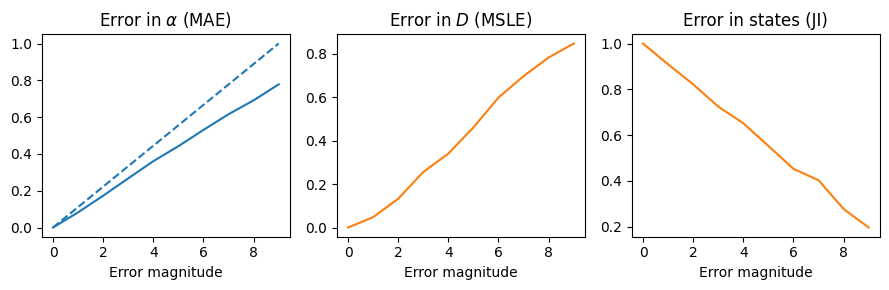

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (9, 3), tight_layout = True)

ax[0].plot(np.arange(ngts), errors_alpha, c = 'C0', ls = '--', label = 'Expected with no assigment error')
ax[0].plot(np.arange(ngts), metric_a, c = 'C0')
ax[0].set_title(r'Error in $\alpha$ (MAE)')

#ax[1].plot(np.arange(ngts), errors_d, c = 'C1', ls = '--')
ax[1].plot(np.arange(ngts), metric_d, c = 'C1')
ax[1].set_title(r'Error in $D$ (MSLE)')

ax[2].plot(np.arange(ngts), metric_s, c = 'C1')
ax[2].set_title(r'Error in states (JI)')

plt.setp(ax, xlabel = 'Error magnitude')

With error in the changepoint predicitions:

[Text(0.5, 0, 'Error magnitude'),
 Text(0.5, 0, 'Error magnitude'),
 Text(0.5, 0, 'Error magnitude')]

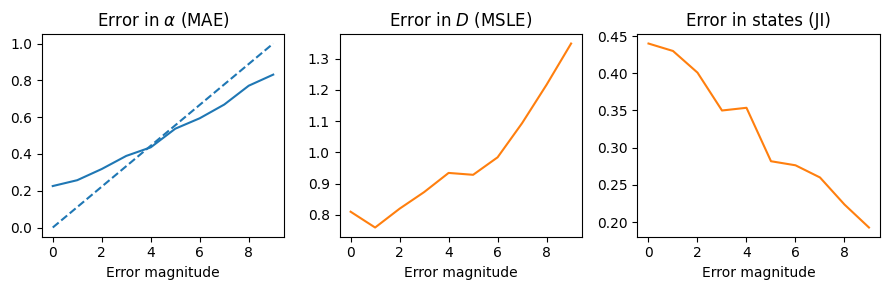

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (9, 3), tight_layout = True)

ax[0].plot(np.arange(ngts), errors_alpha, c = 'C0', ls = '--', label = 'Expected with no assigment error')
ax[0].plot(np.arange(ngts), metric_a, c = 'C0')
ax[0].set_title(r'Error in $\alpha$ (MAE)')

#ax[1].plot(np.arange(ngts), errors_d, c = 'C1', ls = '--')
ax[1].plot(np.arange(ngts), metric_d, c = 'C1')
ax[1].set_title(r'Error in $D$ (MSLE)')

ax[2].plot(np.arange(ngts), metric_s, c = 'C1')
ax[2].set_title(r'Error in states (JI)')

plt.setp(ax, xlabel = 'Error magnitude')

## Ensemble metrics

### Get ensemble information

In [ ]:
#| export
def _visualize_ensemble(ens):
    '''
    Given input ens:
    
    |mu_alpha1      mu_alpha2     ... |
    |sigma_alpha1   sigma_alpha2  ... |
    |mu_D1          mu_D1         ... | 
    |sigma_D1       sigma_D2      ... |
    |counts_state1  counts_state2 ... |
    
    creates a dataframe to visualize parameters.
    '''  

    return pandas.DataFrame(data = ens.transpose(), columns = [r'mean $\alpha$', r'var $\alpha$', r'mean $D$', r'var $D$', '% residence time'])

In [ ]:
#| export
from andi_datasets.models_phenom import models_phenom
def extract_ensemble(state_label, dic):
        ''' 
        Given an array of the diffusive state and a dictionary with the diffusion information,
        returns a summary of the ensemble properties for the current dataset.

        Parameters
        ----------
        state_label : array
            Array containing the diffusive state of the particles in the dataset.
            For multi-state and dimerization, this must be the number associated to the
            state (for dimerization, 0 is free, 1 is dimerized). For the rest, we follow
            the numeration of models_phenom().lab_state.
        dic : dict 
            Dictionary containing the information of the input dataset.
       
       Returns
       -------
       array
           Matrix containing the ensemble information of the input dataset. It has the following shape:
            |mu_alpha1      mu_alpha2     ... |
            |sigma_alpha1   sigma_alpha2  ... |
            |mu_D1          mu_D1         ... | 
            |sigma_D1       sigma_D2      ... |
            |counts_state1  counts_state2 ... |
        '''

        # Single state
        if dic['model'] == 'single_state': 
            ensemble = np.vstack((dic['alphas'][0],
                                   dic['alphas'][1],
                                   dic['Ds'][0],
                                   dic['Ds'][1],
                                   len(state_label)
                                   ))
        # Multi-state
        if dic['model'] == 'multi_state':
            states, counts = np.unique(state_label, return_counts=True)    
            # If the number of visited stated is not equal to the expected number of states
            if len(states) != dic['alphas'].shape[0]:
                states_corrected = np.ones(dic['alphas'].shape[0])
                counts_corrected = np.ones(dic['alphas'].shape[0])
                for s, c in zip(states, counts):
                    counts_corrected[int(s)] = c
            else: 
                counts_corrected = counts

            ensemble = np.vstack((dic['alphas'][:, 0],
                                   dic['alphas'][:, 1],
                                   dic['Ds'][:, 0],
                                   dic['Ds'][:, 1],
                                   counts_corrected
                                   ))

        # Immobile
        if dic['model'] == 'immobile_traps':
            counts = [len(state_label[state_label == models_phenom().lab_state.index('i')]),
                      len(state_label[state_label == models_phenom().lab_state.index('f')])]  
            ensemble = np.vstack(([0, dic['alphas'][0]],
                                   [0, dic['alphas'][1]],
                                   [0, dic['Ds'][0]],
                                   [0, dic['Ds'][1]],
                                   counts
                                   ))
        # dimerization    
        if dic['model'] == 'dimerization':
            counts = [len(state_label[state_label == 0]),
                      len(state_label[state_label == 1])]           
            ensemble = np.vstack((dic['alphas'][:, 0],
                                   dic['alphas'][:, 1],
                                   dic['Ds'][:, 0],
                                   dic['Ds'][:, 1],
                                   counts
                                   ))

        if dic['model'] == 'confinement':
            counts = [len(state_label[state_label == models_phenom().lab_state.index('f')]),
                      len(state_label[state_label == models_phenom().lab_state.index('c')])]   
            ensemble = np.vstack((dic['alphas'][:, 0],
                                   dic['alphas'][:, 1],
                                   dic['Ds'][:, 0],
                                   dic['Ds'][:, 1],
                                   counts
                                   ))
        return ensemble

### Generate distribution and distances

In [ ]:
#| export
import scipy.stats
def multimode_dist(params, weights, bound, x, normalized = False, min_var = 1e-9):
    '''
    Generates a multimodal distribution with given parameters.
    Also accounts for single mode if weight is float or int.
    
    Parameters
    ----------
    params : list
        Mean and variances of every mode.
    weights : list, float
        Weight of every mode. If float, we consider a single mode.
    bound : tuple
        Bounds (min, max) of the functions support.
    x : array
        Support upon which the distribution is created.
    normalize : bool
        If True, returns the normalized distribution.    
    Returns
    -------
    array
        Value of the distribution in each point of the given support
        
    '''
    func = scipy.stats.truncnorm
    dist = np.zeros_like(x)
    lower, upper = bound 
   
    # If we have single state, change values to list to still
    # have a loop:
    if isinstance(weights, float) or isinstance(weights, int):
        params = [params]
        weights = [weights]
        
    for param, w in zip(params, weights):
        mean, var  = param  
        # introduce a cutoff to avoid nan when var = 0
        if var < min_var: var = min_var
        unimodal = func.pdf(x,
                            (lower-mean)/np.sqrt(var),
                            (upper-mean)/np.sqrt(var),
                            loc = mean,
                            scale = np.sqrt(var))
        dist += w*unimodal
    if normalized:
        dist /= np.sum(dist)
    return dist

[<matplotlib.lines.Line2D>]

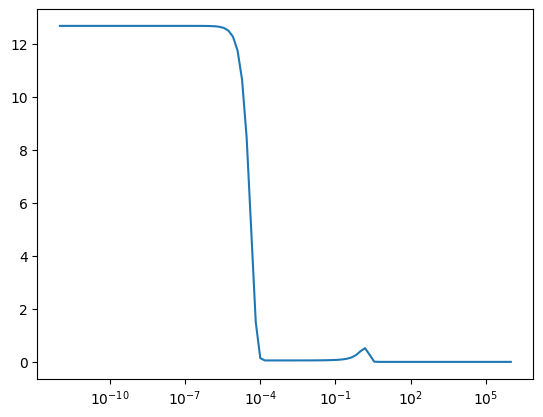

In [ ]:
# True distribution
x = np.logspace(np.log10(models_phenom().bound_D[0]), 
                      np.log10(models_phenom().bound_D[1]), 100)
weights = [0.0005,0.9]
params_true = [[0.0,0],[1.5,0.5]]
true = multimode_dist(params_true, weights, bound = models_phenom().bound_D, x = x, normalized = False, min_var=1e-9)
plt.semilogx(x, true)

In [ ]:
#| export
from scipy.stats import wasserstein_distance

def distribution_distance(p:np.array, # distribution 1
                          q:np.array, # distribution 2
                          x:np.array = None, # support of the distributions (not needed for MAE)
                          metric = 'wasserstein' # distance metric (either 'wasserstein' or 'mae')
                         )-> float:  # distance between distributions
    ''' Calculates distance between two distributions. '''
#     return np.sum(np.where(p != 0, p * np.log(p / q), 0))
    if metric == 'mae':
        return np.abs(p-q).mean()
    elif metric == 'wasserstein':
        return wasserstein_distance(x, x, p, q)

#### Tests distance

##### Normal scenario

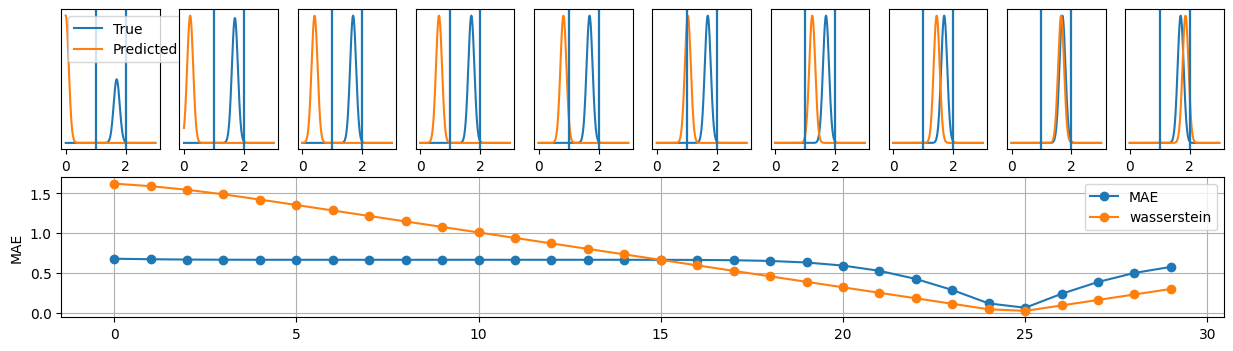

In [ ]:
means = np.linspace(0, 2, 30)
normalize = False
fig = plt.figure(figsize=(15, 4))
gs = fig.add_gridspec(2, 10)

# True distribution
x = np.arange(0, 3, 0.01)
params = [[1.7,0.01]]
weights = [1]
true = multimode_dist(params, weights, bound = [0, 3], x = x, normalized = normalize)

range_x = (1,2)
idx_range = np.argwhere((x>range_x[0]) & (x<range_x[1])).flatten()


MSE = []
wass = []
for idx, mean in enumerate(means):
    params = [[mean, 0.01]]
    weights = [1]
    pred = multimode_dist(params, weights, bound = [0, 3], x = x, normalized = normalize)  
    MSE.append(distribution_distance(true, pred, metric = 'mae'))  
    wass.append(distribution_distance(true, pred, x))  
    
    if idx % 3 == 0:
        
        ax = fig.add_subplot(gs[0, int(idx/3)])
        ax.plot(x, true, label = 'True')
        ax.plot(x, pred, label = 'Predicted')        
        plt.setp(ax, yticks = []);
        
      
    if idx == 0:
        ax.legend()
        
    ax.axvline(range_x[0])
    ax.axvline(range_x[1])
    
ax_dist = fig.add_subplot(gs[1, :])
ax_dist.plot(MSE, '-o', label = 'MAE')
ax_dist.plot(wass, '-o', label = 'wasserstein')
ax_dist.legend()
plt.setp(ax_dist, ylabel = 'MAE')
ax_dist.grid()

##### Having a variance = 0 (as in immobile)

**Wasserstein:**

Text(0, 0.5, 'mse dist')

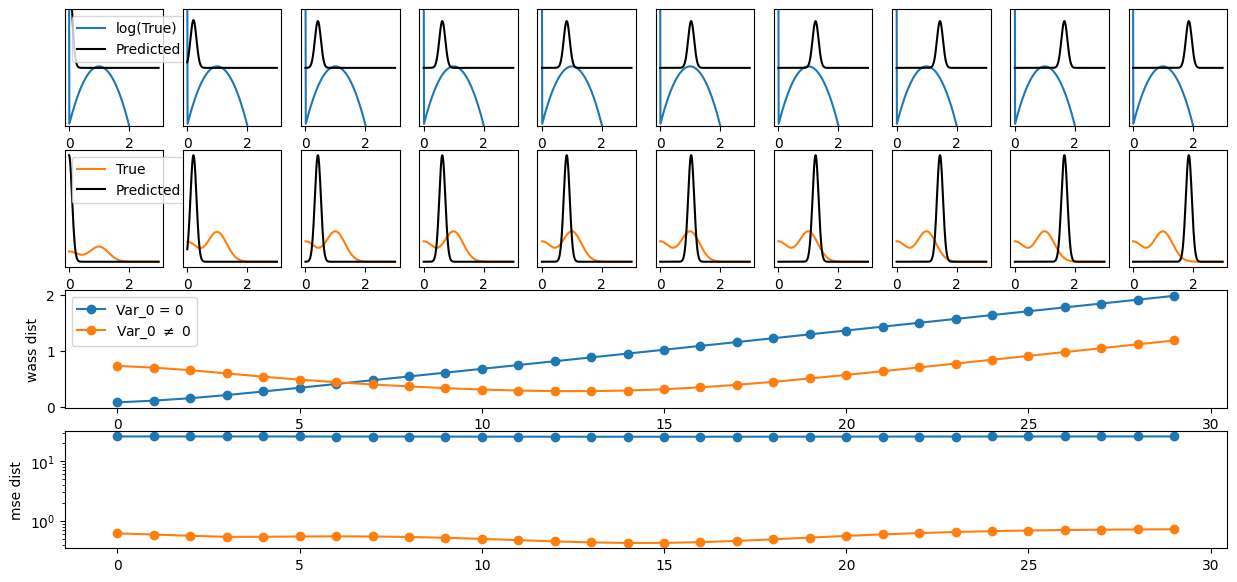

In [ ]:
means = np.linspace(0, 2, 30)
normalize = False

fig = plt.figure(figsize=(15, 7))
gs = fig.add_gridspec(4, 10)

# True distribution
x = np.arange(0, 3, 0.01)
weights = [0.3, 0.9]

params_var0 = [[0,0.0],[1,0.1]]
true_var0 = multimode_dist(params_var0, weights, bound = [0, 3], x = x, normalized = normalize)

params = [[0,0.1],[1,0.1]]
true = multimode_dist(params, weights, bound = [0, 3], x = x, normalized = normalize)

wass_var0 = []
wass = []
mae_var0 = []
mae = []
for idx, mean in enumerate(means):
    params = [[mean, 0.01]]
    weights = [1]
    pred = multimode_dist(params, weights, bound = [0, 3], x = x, normalized = normalize)  
    wass_var0.append(distribution_distance(true_var0, pred, x))  
    wass.append(distribution_distance(true, pred, x))  
    
    mae_var0.append(distribution_distance(true_var0, pred, metric = 'mae'))  
    mae.append(distribution_distance(true, pred, metric = 'mae'))  
    
    if idx % 3 == 0:
        
        ax0 = fig.add_subplot(gs[0, int(idx/3)])
        ax0.plot(x, np.log(true_var0), label = 'log(True)', c = 'C0')
        ax0.plot(x, pred, label = 'Predicted', c = 'k')        
        plt.setp(ax0, yticks = [], ylim = (-5, 5));
        
        ax = fig.add_subplot(gs[1, int(idx/3)])
        ax.plot(x, true, label = 'True', c = 'C1')
        ax.plot(x, pred, label = 'Predicted', c = 'k')        
        plt.setp(ax, yticks = []);
        
      
    if idx == 0:
        ax0.legend()
        ax.legend()

ax_wass = fig.add_subplot(gs[2, :])
ax_wass.plot(wass_var0, '-o', label = 'Var_0 = 0')
ax_wass.plot(wass, '-o', label = r'Var_0 $\neq$ 0')
ax_wass.legend()
ax_wass.set_ylabel('wass dist')

ax_mse = fig.add_subplot(gs[3, :])
ax_mse.plot(mae_var0, '-o', label = 'Var_0 = 0')
ax_mse.plot(mae, '-o', label = r'Var_0 $\neq$ 0')
ax_mse.set_yscale('log')
ax_mse.set_ylabel('mse dist')

# ax_dist.grid()

##### Checking how variance of predicted affects Wasserstein distance:

Text(0, 0.5, 'Wasserstein distance')

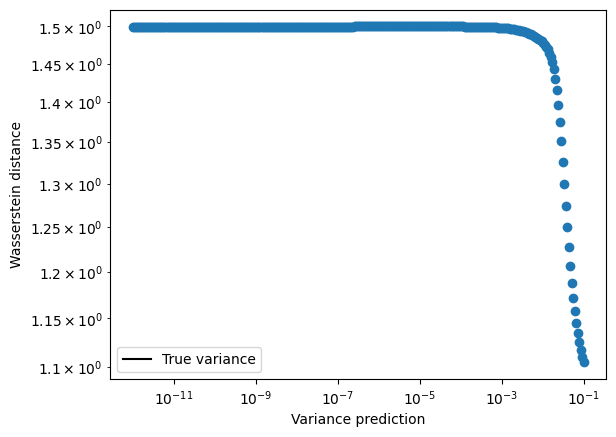

In [ ]:
variances = np.logspace(-12, -1,300)
# True distribution
x = np.logspace(-12, 1, 10000)
weights = [1]
params_true = [[0.0,0]]
true = multimode_dist(params_true, weights, bound = [1e-9, 3], x = x, normalized = normalize, min_var=1e-7)

dist = []
for idx, var in enumerate(variances):
    params = [[0.5, var]]
    weights = [1]
    pred = multimode_dist(params, weights, bound = [1e-9, 3], x = x, normalized = normalize, min_var=1e-7)  
    dist.append(distribution_distance(true, pred, x=x))  
    
plt.plot(variances, np.array(dist)+1, 'o')
plt.axvline(params_true[0][1], c = 'k', label = 'True variance')
plt.legend()
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Variance prediction')
plt.ylabel('Wasserstein distance')

Checking if we are considering a peak at 0

In [ ]:
# True distribution
x = np.logspace(np.log10(models_phenom().bound_D[0]), 
                      np.log10(models_phenom().bound_D[1]), 100)
weights = [0.0005,0.9]
params_true = [[0.0,0],[1.5,0.5]]
true = multimode_dist(params_true, weights, bound = models_phenom().bound_D, x = x, normalized = normalize)


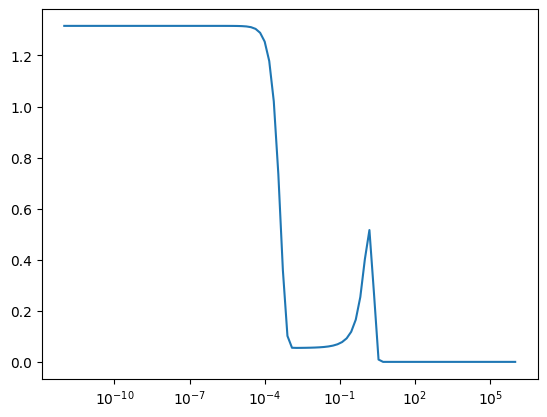

In [ ]:
plt.plot(x, true)
plt.xscale('log')

Testing maximum value of Wasserstein distance for considered $\alpha$ and $D$ ranges

In [ ]:
from andi_datasets.utils_challenge import multimode_dist, distribution_distance

In [ ]:
min_a, max_a = models_phenom().bound_alpha[0], models_phenom().bound_alpha[1]
x = np.arange(min_a, max_a, 0.01)
normalize = False

In [ ]:
distmax = multimode_dist([[max_a,0.0001]], [1], bound = [min_a, max_a], x = x, normalized = normalize)
distmin = multimode_dist([[min_a,0.0001]], [1], bound = [min_a, max_a], x = x, normalized = normalize)

In [ ]:
distribution_distance(distmax, distmin, x)

1.982486622823773

In [ ]:
min_d, max_d = models_phenom().bound_D[0], models_phenom().bound_D[1]
x = np.logspace(np.log10(models_phenom().bound_D[0]), 
                      np.log10(models_phenom().bound_D[1]), 100)

In [ ]:
distmax = multimode_dist([[max_d,0.1]], [1], bound = [min_d, max_d], x = x, normalized = normalize)
distmin = multimode_dist([[min_d,0.01]], [1], bound = [min_d, max_d], x = x, normalized = normalize)

In [ ]:
distribution_distance(distmax, distmin, x)

-0.004896474885754287

### Calculate ensemble metric


In [ ]:
#| export
from andi_datasets.models_phenom import models_phenom

def error_Ensemble_dataset(true_data, pred_data,
                           size_support = 1000,
                           metric = 'wasserstein',
                           return_distributions = False):
    ''' 
    Calculates the ensemble metrics for the ANDI 2 challenge. The input are matrices of shape:
    
    | col1 (state 1) | col2 (state 2) | col3 (state 3) | ... |
    |:--------------:|:--------------:|:--------------:|:---:|
    | $\mu_a^1$      | $\mu_a^2$      | $\mu_a^3$      | ... |
    | $\sigma_a^1$   | $\sigma_a^2$   | $\sigma_a^3$   | ... |
    | $\mu_D^1$      | $\mu_D^2$      | $\mu_D^3$      | ... |        
    | $\sigma_D^1$   | $\sigma_D^2$   | $\sigma_D^3$   | ... |
    | $N_1$          | $N_2$          | $N_3$          | ... |
    
    Parameters
    ----------
    true_data : array
        Matrix containing the groundtruth data.
    pred_data : array
        Matrix containing the predicted data.
    size_support : int
        size of the support of the distributions 
    metric : str
        metric used to calculate distance between distributions
    return_distributions : bool
        If True, the function also outputs the generated distributions.
    
    Returns
    -------
    tuple
        - distance_alpha: distance between anomalous exponents
        - distance_D: distance between diffusion coefficients
        - dists (if asked): distributions of both groundtruth and predicted data. Order: true_a, true_D, pred_a, pred_D        
    
    '''
    # Define the support for the distributions
    x_alpha = np.linspace(models_phenom().bound_alpha[0], 
                          models_phenom().bound_alpha[1], size_support)
    x_D = np.logspace(np.log10(models_phenom().bound_D[0]), 
                      np.log10(models_phenom().bound_D[1]), size_support)  
    
    
    dists = []
    for data in [true_data, pred_data]:
        
        if len(data.shape) > 1: # If we have more than one state
            alpha_info = np.delete(data, [2,3, -1], 0)
            d_info = data[2:-1,:]
            weights = data[-1,:]
            if weights.sum() > 1: weights /= weights.sum()
        else: # If single state
            alpha_info = data[:2]
            d_info = data[2:-1]
            weights = 1
            
        for idx, var in enumerate([alpha_info, d_info]):                                                
            dists.append(multimode_dist(var.T, weights, 
                                        bound  = models_phenom().bound_alpha if idx == 0 else models_phenom().bound_D, 
                                        x = x_alpha if idx == 0 else x_D))
            
    # Distance between alpha dists
    distance_alpha = distribution_distance(p = dists[0], q = dists[2],
                                           x = x_alpha, metric = metric)
    distance_D = distribution_distance(p = dists[1], q = dists[3],
                                       x = x_D, metric = metric)
    
    if return_distributions:
        return distance_alpha, distance_D, dists
    else:
        return distance_alpha, distance_D

In [ ]:
#| eval: false

track = 1
# Choose the paths
PATH_PRED = f'../../testing/data/fourth_round/pred_carlo/Track{track}/'
PATH_TRUE = '../../testing/data/fourth_round/true/fourth_round/'



distance_D, distance_alpha = [], []
for exp in [2]:
    
    true = np.loadtxt(PATH_TRUE+f'exp_{exp}/ensemble_labels.txt', skiprows = 1, delimiter = ';')
    pred = np.loadtxt(PATH_PRED+f'exp_{exp}/ensemble_pred.txt', skiprows = 1, delimiter = ';')
    
    df_true = pandas.DataFrame(data = true.reshape(1,5) if exp == 1 else true.transpose(), 
                           columns = [r'mean $\alpha$', r'var $\alpha$', r'mean $D$', r'var $D$', '% residence time'])
    df_pred = pandas.DataFrame(data = pred.reshape(1,5) if exp == 1 else pred.transpose(), 
                           columns = [r'mean $\alpha$', r'var $\alpha$', r'mean $D$', r'var $D$', '% residence time'])

#     print(f'Experiment {exp}: \nGroundtruth:')
#     display(df_true)
#     print('Prediction:')
#     display(df_pred)
#     print('------ \n')

    distance_D.append(distance_D_exp)
    distance_alpha.append(distance_a_exp)
    
    distance_a_exp, distance_D_exp, dists = error_Ensemble_dataset(true, pred, return_distributions = True)


print(f'Distance distribution D = {np.mean(distance_D)}')
print(fr'Distance distribution $\alpha$ = {np.mean(distance_alpha)}')

Distance distribution D = 0.06045239400247898
Distance distribution $\alpha$ = 0.10273932574583697


## Single trajectory metrics

The participants will have to output predictions in a .txt file were each line corresponds to the predictions of a trajectory. The latter have to be ordered as:

0, d$_0$, a$_0$, s$_0$, t$_1$, d$_1$, a$_1$, s$_1$, t$_2$, d$_2$, a$_2$, s$_2$, .... t$_n$, d$_n$, a$_n$, s$_n$,$T$

where the first number corresponds to the trajectory index, then d$_i$, a$_i$, s$_i$ correspond to the diffusion coefficient, anomalous exponent and diffusive state of the $i$-th segment. For the latter, we have the following code:
 - 0: immobile
 - 1: confined
 - 2: free (unconstrained)
 - 3: directed
 
Last, t$_j$ corresponds to the $j$-th changepoints. The last changepoint $T$ corresponds to the length of the trajectory. Each prediction **must** contain $C$ changepoints and $C$ segments property values. If this is not fulfilled, the whole trajectory is considered as mispredicted.

The .txt file will be first inspected. The data will then be collected into a dataframe

In [ ]:
#| export
def check_prediction_length(pred):
    '''
    Given a trajectory segments prediction, checks whether it has C changepoints and C+1 segments properties values.
    As it must also contain the index of the trajectory, this is summarized by being multiple of 4. 
    In some cases, the user needs to also predict the final point of the trajectory. In this case, 
    we will have a residu of 1.
    '''
    if len(pred) % 4 == 0 or len(pred) % 4 == 1 :
        return True
    else: 
        return False

In [ ]:
#| export
def separate_prediction_values(pred):
    '''
    Given a prediction over trjaectory segments, extracts the predictions for each segment property
    as well as the changepoint values.
    '''        
    Ds = pred[1::4]
    alphas = pred[2::4]
    states = pred[3::4]
    cp = pred[4::4]    
    return Ds, alphas, states, cp

In [ ]:
#| export
def load_file_to_df(path_file, 
                    columns = ['traj_idx', 'Ds', 'alphas', 'states', 'changepoints']):
    '''
    Given the path of a .txt file, extract the segmentation predictions based on 
    the rules of the ANDI 2 challenge022
    '''

    with open(path_file) as f:
        lines_pred = f.read().splitlines()

    df = pandas.DataFrame(columns = columns)

    for line in lines_pred:
        # Extract values with comma separator and transform to float
        pred_traj = line.split(',')
        pred = [float(i) for i in pred_traj]
        
        # Check that prediction has the correct shape
        pred_correct = check_prediction_length(pred)
        
        # If correct size, then extract parameters and add it to dataframe
        if pred_correct:
            preds_D, preds_a, preds_s, preds_cp = separate_prediction_values(pred)

            current_row = df.shape[0]
            for param, pred_param in zip(columns, [pred[0], preds_D, preds_a, preds_s, preds_cp]):
                df.loc[current_row, param] = pred_param
                
    return df

Saving fake data for test

In [ ]:
#| eval:false
file_gt, file_p = [], []
T = 200; ngts = 10;
for traj in range(100):
    GT_cp = np.sort(np.random.choice(np.arange(1,T), ngts, replace = False))
    preds_cp = np.sort(np.random.choice(np.arange(1,T+50), ngts, replace = False)) 

    GT_alpha = np.random.rand(GT_cp.shape[0]+1)
    preds_alpha = GT_alpha# + 0.1 #np.random.randn(preds_cp.shape[0]+1)*0.1

    GT_D = np.abs(np.random.randn(GT_cp.shape[0]+1)*10)
    preds_D = GT_D + 1.5 #np.abs(np.random.randn(preds_cp.shape[0]+1))*1.6
    
    GT_state = np.random.randint(0, high = 5, size = GT_cp.shape[0]+1)
    preds_state = np.random.randint(0, high = 5, size = preds_cp.shape[0]+1)
    
    list_gt, list_p = [traj, GT_D[0], GT_alpha[0], GT_state[0]], [traj, preds_D[0], preds_alpha[0], preds_state[0]]
    for gtc, gta, gtd, gts, pc, pa, pd, ps in zip(GT_cp, GT_alpha[1:], GT_D[1:], GT_state[1:], preds_cp, preds_alpha[1:], preds_D[1:], preds_state[1:]):
        list_gt += [gtc, gtd, gta, gts]
        list_p += [pc, pd, pa, ps]
        
    file_gt.append(list_gt)
    if traj != 6:
        file_p.append(list_p)
        
pred_path, true_path = 'pred_test.txt', 'true_test.txt'
np.savetxt(true_path, file_gt, delimiter=',')
np.savetxt(pred_path, file_p, delimiter=',')

Recovering the data

In [ ]:
#| eval:false
pred_path, true_path = 'pred_test.txt', 'true_test.txt'

df_pred = load_file_to_df(pred_path)
df_true = load_file_to_df(true_path)

In [ ]:
#| export
def error_SingleTraj_dataset(df_pred, df_true, 
                              threshold_error_alpha = None, max_val_alpha = 2, min_val_alpha = 0, 
                              threshold_error_D = None, max_val_D = 1e6, min_val_D = 1e-6, 
                              threshold_error_s = None,
                              threshold_cp = None,
                              prints = True, disable_tqdm = False
                             ):
    '''
    Given two dataframes, corresponding to the predictions and true labels of a set
    of trajectories from the ANDI 2 challenge022, calculates the corresponding metrics
    Columns must be for both (no order needed):
    traj_idx | alphas | Ds | changepoints | states
    df_true must also contain a column 'T'.
    
    Parameters
    ----------
    df_pred : dataframe
        Predictions
    df_true : dataframe
        Groundtruth
    threshold_error_alpha : float
        (same for D, s, cp) Maximum possible error allowed. If bigger, it is substituted by this error.
    max_val_alpha : float
        (same for D, s, cp) Maximum value of the parameter.
    min_val_alpha : float
        (same for D, s, cp) Minimum value of the parameter.
    print : bool
        If True, prints the results.
    disable_tqdm : bool
        If True, disables the progress bar.
    
    Returns
    -------
    tuple
        - rmse_CP: root mean squared error change points
        - JI: Jaccard index change points
        - error_alpha: mean absolute error anomalous exponents
        - error_D: mean square log error diffusion coefficients
        - error_s: Jaccar index diffusive states
    
    '''
    # Check error bounds
    andi_bounds = _get_error_bounds()
    if threshold_error_alpha is None: threshold_error_alpha = andi_bounds[0]
    if threshold_error_D is None: threshold_error_D = andi_bounds[1]
    if threshold_error_s is None: threshold_error_s = andi_bounds[2]
    if threshold_cp is None: threshold_cp = andi_bounds[3]
    
    # Initiate counting missing trajectories
    missing_traj = False
    
    # Deleter saving variables, just in case...
    try: del paired_alpha, paired_D, paired_s
    except: pass

    # for every trajectory, we stack paired segment properties. We also store changepoints info
    ensemble_pred_cp, ensemble_true_cp = [], []
    for t_idx in tqdm(df_true['traj_idx'].values, disable = disable_tqdm):
        
        traj_trues = df_true.loc[df_true.traj_idx == t_idx]

        traj_preds = df_pred.loc[df_pred.traj_idx == t_idx]    
        if traj_preds.shape[0] == 0 or len(traj_preds.changepoints.to_list()[0]) == 0:
            # If there is no trajectory, we give maximum error. To do so, we redefine predictions
            # and trues so that they give maximum error
            missing_traj += 1                       
            
            preds_cp, preds_alpha, preds_D, preds_s = [[10],
                                                       [0],
                                                       [1],
                                                       [0]]

            trues_cp, trues_alpha, trues_D, trues_s = [[10+threshold_cp],
                                                       [threshold_error_alpha],
                                                       [1+threshold_error_D],
                                                       [10]]
        
        else:      

            preds_cp, preds_alpha, preds_D, preds_s = [np.array(traj_preds.changepoints.values[0]).astype(int),
                                                       traj_preds.alphas.values[0],
                                                       traj_preds.Ds.values[0],
                                                       traj_preds.states.values[0]]

            trues_cp, trues_alpha, trues_D, trues_s = [np.array(traj_trues.changepoints.values[0]).astype(int),
                                                       traj_trues.alphas.values[0],
                                                       traj_trues.Ds.values[0],
                                                       traj_trues.states.values[0]]


        # Collecting changepoints for metric
        # In this metric, we don't want to enter the final point of the trajectory
        ensemble_pred_cp.append(preds_cp[:-1])
        ensemble_true_cp.append(trues_cp[:-1])        
        
        # collecting segment properties error after segment assignment
        pair_a, pair_d, pair_s = segment_property_errors(trues_cp, trues_alpha, trues_D, trues_s, 
                                                         preds_cp, preds_alpha, preds_D, preds_s,
                                                         return_pairs = True)
        

        
        try:
            paired_alpha = np.vstack((paired_alpha, pair_a))
            paired_D = np.vstack((paired_D, pair_d))
            paired_s = np.vstack((paired_s, pair_s))        
        except:
            paired_alpha = pair_a
            paired_D = pair_d
            paired_s = pair_s
               
    #### Calculate metrics from assembled properties   

    # checking for nans and problems in predictions
    wrong_alphas = np.argwhere(np.isnan(paired_alpha[:, 1]) | (paired_alpha[:, 1] > 2) | (paired_alpha[:, 1] < 0)).flatten()
    paired_alpha[wrong_alphas, 1] = paired_alpha[wrong_alphas, 0] + threshold_error_alpha

    wrong_ds = np.argwhere(np.isnan(paired_D[:, 1])).flatten()
    paired_D = np.abs(paired_D)
    paired_D[wrong_ds, 1] = paired_D[wrong_ds, 0] + threshold_error_D
    
    wrong_s = np.argwhere((paired_s[:, 1] > 4) | (paired_s[:, 1]<0))
    paired_s[wrong_s, 1] = threshold_error_s    
    
    # Changepoints
    rmse_CP, JI = ensemble_changepoint_error(ensemble_true_cp, ensemble_pred_cp, threshold = threshold_cp)
        
    # Segment properties
    error_alpha = metric_anomalous_exponent(paired_alpha[:,0], paired_alpha[:,1])
    error_D = metric_diffusion_coefficient(paired_D[:,0], paired_D[:,1])
    error_s = metric_diffusive_state(paired_s[:,0], paired_s[:,1])
    
    if prints:        
        print(f'Summary of metrics assesments:')
        if missing_traj is not False:            
            print(f'\n{missing_traj} missing trajectory/ies. ')
            
        print(f'\nChangepoint Metrics \nRMSE: {round(rmse_CP, 3)} \nJaccard Index: {round(JI, 3)}',
              f'\n\nDiffusion property metrics \nMetric anomalous exponent: {error_alpha} \nMetric diffusion coefficient: {error_D} \nMetric diffusive state: {error_s}')
              
              

    return rmse_CP, JI, error_alpha, error_D, error_s

####  Test

In [ ]:
#| hide
from andi_datasets.models_phenom import models_phenom
# from andi_datasets.utils_challenge import array_to_df, error_SingleTraj_dataset

# For testing of error_SingleTraj_dataset from file: comment previous line and uncomment next one
from andi_datasets.utils_challenge import (_get_error_bounds, segment_property_errors, ensemble_changepoint_error, metric_anomalous_exponent,
                                           metric_diffusion_coefficient, metric_diffusive_state)

**Two datasets with same number of trajs**

In [ ]:
#|eval: false
trajs, labels = models_phenom().immobile_traps(T = 200, N = 250, alphas=0.5, Ds = 1, L = 20, Nt = 100, Pb = 1, Pu = 0.5)

trajs = trajs.transpose((1, 0, 2)).copy()
labels = labels.transpose(1, 0, 2)

df_in, df_trues = array_to_df(trajs, labels)

trajs, labels = models_phenom().immobile_traps(T = 200, N = 250, alphas=[0.5, 0.1], Ds = 1, L = 20, Nt = 100, Pb = 1, Pu = 0.5)

trajs = trajs.transpose((1, 0, 2)).copy()
labels = labels.transpose(1, 0, 2)

df_in, df_preds = array_to_df(trajs, labels)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
#|eval: false
error_SingleTraj_dataset(df_preds, df_trues, prints = True, disable_tqdm=True);

Summary of metrics assesments:

Changepoint Metrics 
RMSE: 4.285 
Jaccard Index: 0.421 

Diffusion property metrics 
Metric anomalous exponent: 0.30181845745010744 
Metric diffusion coefficient: 0.22899984105532623 
Metric diffusive state: 0.5233668341708543


**Two datasets with different number of trajectories**

In [ ]:
#|eval: false
trajs, labels = models_phenom().immobile_traps(T = 200, N = 350, alphas=[0.5,0.01], Ds = [1., 0.1], L = 20, Nt = 100, Pb = 1, Pu = 0.5)

trajs = trajs.transpose((1, 0, 2)).copy()
labels = labels.transpose(1, 0, 2)

df_in, df_trues = array_to_df(trajs, labels, label_values=[0.5, 1], diff_states=[3, 2])

trajs, labels = models_phenom().immobile_traps(T = 200, N = 250, alphas=[0.5, 0.1], Ds = 1, L = 20, Nt = 100, Pb = 1, Pu = 0.5)

trajs = trajs.transpose((1, 0, 2)).copy()
labels = labels.transpose(1, 0, 2)

df_in, df_preds = array_to_df(trajs, labels, label_values=[0.5, 1], diff_states=[3, 2])

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
#|eval: false
error_SingleTraj_dataset(df_preds, df_trues, prints = True)

  0%|          | 0/350 [00:00<?, ?it/s]

Summary of metrics assesments:

100 missing trajectory/ies. 

Changepoint Metrics 
RMSE: 4.051 
Jaccard Index: 0.441 

Diffusion property metrics 
Metric anomalous exponent: 0.35483874584715985 
Metric diffusion coefficient: 3.1690909054732668 
Metric diffusive state: 0.4913685263947961


(4.050708208970335,
 0.4407643312101911,
 0.35483874584715985,
 3.1690909054732668,
 0.4913685263947961)

In [ ]:
#|eval: false
trajs, labels = models_phenom().immobile_traps(T = 200, N = 5, alphas=[0.5,0.01], Ds = [1., 0.1], L = 20, Nt = 100, Pb = 1, Pu = 0.5)

trajs = trajs.transpose((1, 0, 2)).copy()
labels = labels.transpose(1, 0, 2)

df_in, df_preds  = array_to_df(trajs, labels, label_values=[0.5, 1], diff_states=[3, 2])

trajs, labels = models_phenom().multi_state(T = 200, N = 7, L = 20, M = np.array([[0.9,0.1],[0.9,0.1]]))

trajs = trajs.transpose((1, 0, 2)).copy()
labels = labels.transpose(1, 0, 2)

df_in, df_trues  = array_to_df(trajs, labels, label_values=[0.5, 1], diff_states=[3, 2])


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
#|eval: false
error_SingleTraj_dataset(df_preds, df_trues, prints = True);

  0%|          | 0/7 [00:00<?, ?it/s]

Summary of metrics assesments:

2 missing trajectory/ies. 

Changepoint Metrics 
RMSE: 2.903 
Jaccard Index: 0.188 

Diffusion property metrics 
Metric anomalous exponent: 0.8269399281523714 
Metric diffusion coefficient: 8.262443034681892 
Metric diffusive state: 0.41379310344827586


**Dataset with no changepoints**

In [ ]:
#|eval: false
L = 250
# TRUES
trajs, labels = models_phenom().single_state(T = 200, N = 250, alphas=[0.5, 0.01], Ds = [1,0], L = L)
trajs = trajs.transpose((1, 0, 2)).copy()
labels = labels.transpose(1, 0, 2)

df_in, df_trues = array_to_df(trajs, labels, fov_length = L)

# PREDS
trajs, labels = models_phenom().single_state(T = 200, N = 250, L = L)

trajs = trajs.transpose((1, 0, 2)).copy()
labels = labels.transpose(1, 0, 2)

df_in, df_preds = array_to_df(trajs, labels, fov_length = L)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
#|eval: false
error_SingleTraj_dataset(df_preds, df_trues, prints = True, disable_tqdm=True);

Summary of metrics assesments:

Changepoint Metrics 
RMSE: 0 
Jaccard Index: 1 

Diffusion property metrics 
Metric anomalous exponent: 0.5025766161725703 
Metric diffusion coefficient: 0.0 
Metric diffusive state: 1.0


# Codalab scoring program

In [ ]:
#| export
import re
import sys
import os

## Single trajectory

In [ ]:
#| export
def when_error_single(wrn_str):
    # Giving back max_errors for all variables when encountered an error
    # Order of variables is 'cp','JI','alpha','D','state' (as in the dataframe). See that this is not the same order as _get_error_bounds
    warnings.warn(wrn_str)   
    
    
    max_error_alpha = _get_error_bounds()[0]
    max_error_D = _get_error_bounds()[1]
    max_error_s = _get_error_bounds()[2]
    max_error_cp = _get_error_bounds()[3]
    max_error_JI = 0
    
    return (max_error_cp, max_error_JI, max_error_alpha, max_error_D, max_error_s) , pandas.DataFrame(data = np.array([None]*7).reshape(1,7), 
                                                                                                      columns = ['Exp', 'num_trajs', 'RMSE CP', 
                                                                                                                 'JSC CP', 'alpha', 'K', 'state'])


def run_single_task(exp_nums, track, submit_dir, truth_dir):
    
    data_metrics = []

    for exp in exp_nums:

        try:
            del df_true_exp, df_pred_exp
        except:
            pass

        path_pred = submit_dir+f'/track_{track}/exp_{exp}/'
        path_true = truth_dir+f'/track_{track}/exp_{exp}/'
        prefix_true = 'traj_labs_'

        # Get the number of FOVs from the trues
        fov_nums = 0
        for filename in os.listdir(path_true):
            if filename.startswith(prefix_true):
                fov_nums += 1

        for fov in range(fov_nums):
            # Predictions
            corresponding_submission_file = path_pred+f'fov_{fov}.txt'
            
            ### If one file does not exists, abort a return Nones ###
            if not os.path.isfile(corresponding_submission_file):
                wrn_str = f'Prediction missing for: -- Track {track} | Task SingleTraj  | Experiment {exp} | FOV {fov} -- not found and will not be computed.'
                return when_error_single(wrn_str)
                
                
            else:
                preds_fov = load_file_to_df(corresponding_submission_file)

            # Groundtruths
            trues_fov = load_file_to_df(path_true+prefix_true+f'fov_{fov}.txt')

            if track == 1:
                vip_idx = np.loadtxt(path_true + f'vip_idx_fov_{fov}.txt').astype(int)
                pred_vip_idx = preds_fov.traj_idx.values.astype(int)

                if len(vip_idx) != len(pred_vip_idx) or (np.sort(vip_idx) != np.sort(pred_vip_idx)).any():
                    wrn_str = f'Index of predicted VIP  particles does not correspond to true values (Track {track}, Exp {exp}, FOV {fov}). Be sure to correctly extract the correct index from the .tiff file'
                    return when_error_single(wrn_str)
                
                # Take only VIP particles here (pred already contains only vip)
                trues_fov = trues_fov[trues_fov['traj_idx'].isin(vip_idx)]

            # Sort dataframes by the traj idx (so that index and rows correspond)
            trues_fov = trues_fov.sort_values('traj_idx')
            preds_fov = preds_fov.sort_values('traj_idx')

            # Full experiment dataframe
            try:
                trues_fov.traj_idx += df_true_exp.traj_idx.values[-1]+1
                preds_fov.traj_idx += df_pred_exp.traj_idx.values[-1]+1

                df_pred_exp = pandas.concat([df_pred_exp, preds_fov])
                df_true_exp = pandas.concat([df_true_exp, trues_fov]) 
            except:            
                df_pred_exp = preds_fov
                df_true_exp = trues_fov

        # Calculate error for each experiment
        rmse_CP_exp, JI, error_alpha_exp, error_D_exp, error_s_exp = error_SingleTraj_dataset(df_pred_exp, df_true_exp, prints = False, disable_tqdm=True);

        # Save errors and number of trajectories of later doing average
        data_metrics.append([exp, df_true_exp.shape[0], rmse_CP_exp, JI, error_alpha_exp, error_D_exp, error_s_exp])

    # Put all results in dataframe    
    data_metrics = pandas.DataFrame(data = data_metrics, columns = ['Exp', 'num_trajs', 'RMSE CP', 'JSC CP', 'alpha', 'K', 'state'])
    # Calculate weighted averages
    avg_metrics = []
    for key in data_metrics.keys()[2:]:
        avg_metrics.append(np.average(data_metrics[key], weights=data_metrics.num_trajs))

    return avg_metrics, data_metrics
    

#| hide
#### Testing

In [ ]:
#| hide
#| eval: false
from andi_datasets.utils_challenge import run_single_task

## For testing, uncomment following and comment previous
# import os
# from andi_datasets.utils_challenge import error_SingleTraj_dataset, load_file_to_df, error_Ensemble_dataset
# import pandas
# import numpy as np

In [ ]:
#| hide
#| eval: false
avg, df_single = run_single_task(exp_nums = [0,1,2,3,4],
                                 track = 1,
                                 submit_dir = '/home/gorka/andi2_datasets/public_data_v0/intentional_error_data/from_fifth_round/res/',
                                 truth_dir = '/home/gorka/andi2_datasets/public_data_v0/intentional_error_data/from_fifth_round/ref/',
                                )

/home/gorka/github/andi_datasets/andi_datasets/utils_challenge.py:1478: UserWarning: Prediction missing for: -- Task 1 | Track 1 | Experiment 0 | FOV 0 -- not found. Task 1 will not be computed.
  warnings.warn(wrn_str)


## Ensemble

In [ ]:
#| export
def run_ensemble_task(exp_nums, track, submit_dir, truth_dir):
    
    avg_alpha, avg_d = [], []
    
    
    # We keep track in case the file for one experiment is missing. If for at least one we can't find
    # it, we give None as results
    filename = 'ensemble_labels.txt'
    
    
    for exp in exp_nums:
        

        path_pred = submit_dir+f'/track_{track}/exp_{exp}/'
        path_true = truth_dir+f'/track_{track}/exp_{exp}/'
         
        try:

            true = np.loadtxt(path_true+filename, skiprows = 1, delimiter = ';')
            pred = np.loadtxt(path_pred+filename, skiprows = 1, delimiter = ';')

            distance_a_exp, distance_d_exp, dists = error_Ensemble_dataset(true, pred, return_distributions = True)

            avg_alpha.append(distance_a_exp)
            avg_d.append(distance_d_exp)
            
        except:
            wrn_str = f'Prediction missing for: -- Track {track} | Task Ensemble | Experiment {exp} -- not found and will not be computed.'
            warnings.warn(wrn_str)
            # Get the max error possible for the task
            _,_,_,_, max_error_a, max_error_D = _get_error_bounds()
            
            return (max_error_a, max_error_D), pandas.DataFrame(data = np.array([None, None, None]).reshape(1,3), 
                                              columns = ['Exp', 'alpha', 'K']) 
        
    data_metrics = pandas.DataFrame(data = np.vstack((np.arange(len(avg_alpha)),avg_alpha, avg_d)).transpose(),
                                    columns = ['Exp', 'alpha', 'K'])
    data_metrics['Exp'] = data_metrics['Exp'].values.astype(int)
        
    return (np.mean(avg_alpha), np.mean(avg_d)),  data_metrics

In [ ]:
#| hide
#| eval: false
avg, df_ens = run_ensemble_task(exp_nums = [0,1,2,3,4],
                                 track = 2,
                                 submit_dir = '/home/gorka/github/andi_codalab_bundle/data/pre_challenge/res',
                                 truth_dir = '/home/gorka/github/andi_codalab_bundle/data/pre_challenge/ref',
                                )

## Parent program

In [ ]:
#| export
import os

def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith(('.','_')):
            yield f

def codalab_scoring(INPUT_DIR = None, # directory to where to find the reference and predicted labes
                    OUTPUT_DIR = None # directory where the scores will be saved (scores.txt)
                   ):
    
    if INPUT_DIR is None:
        INPUT_DIR = sys.argv[1]
    if OUTPUT_DIR is None:
        OUTPUT_DIR = sys.argv[2]
        
    submit_dir = os.path.join(INPUT_DIR, 'res')
    truth_dir = os.path.join(INPUT_DIR, 'ref')
    
    
    # Starting the HMTL file
    htmlOutputDir = os.path.join(OUTPUT_DIR, "html")
    if not os.path.exists(htmlOutputDir):
            os.makedirs(htmlOutputDir)
    html_filename = os.path.join(htmlOutputDir, 'scores.html')
    html_file = open(html_filename, 'a', encoding="utf-8")
    html_file.write('<h1>Submission detailed results </h1>')

    if not os.path.isdir(submit_dir):
        print( "%s doesn't exist", submit_dir)
        
    if os.path.isdir(submit_dir) and os.path.isdir(truth_dir):
        if not os.path.exists(OUTPUT_DIR):
            os.makedirs(OUTPUT_DIR)

    output_filename = os.path.join(OUTPUT_DIR, 'scores.txt')
    output_file = open(output_filename, 'w')
       
    

    # Track 1: videos
    # Track 2: trajectories
    for track, name_track in zip([1,2], ['videos', 'trajectories']):
        
        ##### ----- In case the whole track is missing, give Nones to both tasks ----- #####
        path_preds = os.path.join(INPUT_DIR, f'res/track_{track}')
        
        if not os.path.exists(path_preds):
            wrn_str = f'No submission for track {track} found.'
            warnings.warn(wrn_str)
            
            for task in enumerate(['single', 'ensemble']): 
                # Codalab naming:
                # task 1 : single traj
                # task 2: ensemble
                idx_task = 1 if task == 'single' else 2
                
                # single trajectories
                if task == 'single':                    
                    for name, max_error in zip(['alpha','D','state', 'cp','JI'], list(_get_error_bounds()[:-2])+[0]): # This names must be the same as used in the yaml leaderboard                  
                        output_file.write(f'tr{track}.ta1{idx_task}.'+name+': '+str(max_error) +'\n')
                elif task == 'ensemble':
                    for name, max_error in zip(['alpha','D'], _get_error_bounds()[-2:]): # This names must be the same as used in the yaml leaderboard
                        output_file.write(f'tr{track}.ta{idx_task}.'+name+': '+str(max_error) +'\n')
            continue
        ##### ------------------------------------------------------------------------ #####
        
        
        html_file.write(f'<h2> Track {track}: '+name_track+' </h2>')

        for task in ['ensemble', 'single']: 

            # Codalab naming:
            # task 1 : single traj
            # task 2: ensemble
            idx_task = 1 if task == 'single' else 2
            
            if task == 'single':
                html_file.write(f'<h3> Single Trajectory Task </h3>')
            elif task == 'ensemble':
                html_file.write(f'<h3> Ensemble Task </h3>')


            # Get the number of experiments from the true directory
            exp_folders = sorted(list(listdir_nohidden(truth_dir+f'/track_{track}')))
            exp_nums = [int(name[-1]) for name in exp_folders]

            if task == 'single':  

                avg_metrics, df = run_single_task(exp_nums, track, submit_dir, truth_dir )

                for name, res in zip(['cp','JI','alpha','D','state'], avg_metrics): # This names must be the same as used in the yaml leaderboard                  
                    output_file.write(f'tr{track}.ta{idx_task}.'+name+': '+str(res) +'\n')

                ''' To keep consistency with leaderboard display, we swap the K and alpha columns that
                get printed in the detailed results.
                Moreover, we change the names to match leaderboard. '''
                df_swapped = df.iloc[:,[0,1,2,3,5,4,6]]
                df_swapped = df_swapped.rename(columns = {'alpha': 'MAE (alpha)', 'K': 'MSLE (K)',
                                                          'RMSE CP': 'RMSE (CP)', 'JSC CP': 'JSC (CP)',
                                                          'state': 'F1 (diff. type)'})
                # Changing the name of JI to JSC to match paper nomenclature
                html_file.write(df_swapped.to_html(index = False).replace('\n',''))
              

            if task == 'ensemble':

                avg_metrics, df = run_ensemble_task(exp_nums, track, submit_dir, truth_dir)
                
                ''' There was a problem with the leaderboard labels and we had to SWAP alpha and D in the 
                first element of the zip, i.e. the list is now ['D', 'alpha'] but avg_metrics is [alpha, D] '''
                for name, res in zip(['D','alpha'], avg_metrics):                
                    output_file.write(f'tr{track}.ta{idx_task}.'+name+': '+str(res) +'\n')      

                ''' To keep consistency with leaderboard display, we swap the K and alpha columns that
                get printed in the detailed results.
                Moreover, we change the names to match leaderboard. '''
                df_swapped = df.iloc[:,[0,2,1]]                
                df_swapped = df_swapped.rename(columns = {'alpha': r'W1 (alpha)', 'K': 'W1 (K)'})
                
                html_file.write(df_swapped.to_html(index = False).replace('\n',''))
   

    html_file.close()
    output_file.close()  
        

In [ ]:
#| hide
# from andi_datasets.utils_challenge import codalab_scoring

## For testing comment previous line and uncomment following
from andi_datasets.utils_challenge import error_Ensemble_dataset, _get_error_bounds, load_file_to_df, error_SingleTraj_dataset
from andi_datasets.utils_challenge import run_single_task, run_ensemble_task

In [ ]:
#| hide
#| eval: false
codalab_scoring(INPUT_DIR = '/home/gorka/github/andi_codalab_bundle/data/pre_challenge/',
                OUTPUT_DIR = '.')

#| hide

## Single file for codalab
> This will be copy-pasted into a .py for the scoring program

In [ ]:
#| hide
#| eval: false
import sys
# The following update will only occur on the server. To be able to run this cell in a notebook, we 
# create this try /except which prevents repo updates if working from notebooks
try:
    __IPYTHON__
    print('working in notebook!')
    
except NameError:
    ############################################ TO UPDATE THE REPO ###########################################
    
    try:
        import git     
    except:
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", 'git'])    
    
    def has_changes(local_path, branch_name="main"):
        repo = git.Repo(local_path)

        # Fetch updates from the remote repository
        repo.remotes.origin.fetch()

        # Get the current local branch
        local_branch = repo.active_branch

        # Get the branch you want to compare (e.g., 'main')
        remote_branch = repo.remotes.origin.refs[branch_name]

        # Check if there are any changes
        has_changes = repo.is_ancestor(local_branch.commit, remote_branch.commit)

        return has_changes


    def update_repo(local_path):
        repo = git.Repo(local_path)

        # Pull changes from the remote repository
        repo.remotes.origin.pull()


    repo_path = "/app/andi_files/"

    if has_changes(repo_path, branch_name="codalab_andi2"):
        update_repo(repo_path)
   
    
    # add to path
    sys.path.append("/app/andi_files/")
    
    ############################################ TO UPDATE THE REPO ###########################################

from andi_datasets.utils_challenge import codalab_scoring

codalab_scoring(INPUT_DIR = sys.argv[1],
                OUTPUT_DIR = sys.argv[2]
               )

# codalab_scoring(INPUT_DIR = '/home/gorka/andi2_datasets/public_data_v0/correct_data/',
#                 OUTPUT_DIR = '/home/gorka/github/andi_datasets/source_nbs/lib_nbs'
#                )

working in notebook!


/home/gorka/miniconda3/envs/andi/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gorka/miniconda3/envs/andi/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gorka/miniconda3/envs/andi/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gorka/miniconda3/envs/andi/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Helpers transform results dataset in reference dataset

In [ ]:
#| export
import glob
# Function to rename and delete files as required
def transform_ref_to_res(base_path : str, # path where to find the folder to reorganize
                         track : str, # either 'track_1' or 'track_2'
                         num_fovs : int
                        ):
    
    ''' Transforms an organized reference dataset into a valid submission dataset. Note that we 
    do not account for VIP indices in track_1, so will later yield an error when scoring this track.'''
    
    
    fov_range = range(num_fovs)
    
    # Iterate through each experiment directory
    for exp_dir in os.listdir(os.path.join(base_path, track)):
        exp_path = os.path.join(base_path, track, exp_dir)

        # Rename traj_labs_fov_X.txt to fov_X.txt
        for fov in fov_range:
            old_name = os.path.join(exp_path, f'traj_labs_fov_{fov}.txt')
            new_name = os.path.join(exp_path, f'fov_{fov}.txt')
            if os.path.exists(old_name):
                os.rename(old_name, new_name)

        # Delete all files except ensemble_labels.txt
        for file in glob.glob(os.path.join(exp_path, '*')):
            if not (file.endswith('ensemble_labels.txt') or os.path.basename(file).startswith('fov_')):
                os.remove(file)

#| hide
# NBDEV Export

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()